In [215]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Task description

**Task 2: Data Insights**
You are tasked with helping the Supply Product team to better understand user interaction,
metrics and engagement of FREENOW drivers:



**1.Freenow_drivers**

A user table with data on FREE NOW drivers including:
- ***Id_driver:*** the driver ID
- ***Date_registration:*** the date when the user was activated in FREE NOW
- ***Driver_rating:*** the average rating of the driver last 100 rides
- ***Gold_level_count:*** amount of times the driver reached gold status meaning they were
    among the top performers in a specific week
- ***Receive_marketing:*** Takes one of two values, True if the driver accepted to receive
    marketing and campaign communications and False, if not
- ***Country_code:*** Country where the user operates
- ***Service_type:*** If the user is TAXI or a Private Hire Vehicle (PHV)

**2. Freenow_drivers_activity**

A summary of the user activity including:
- ***Id_driver:*** the driver ID
- ***Active_date:*** date when the user operated in the platform
- ***Offers:*** number of requests for a ride that a driver received
- ***Bookings:*** number of requests accepted by the driver
- ***Bookings_cancelled_by_passenger:*** number of requests accepted by the driver and then
    cancelled by the passenger, before the ride was completed
- ***Bookings_cancelled_by_driver:*** number of requests accepted by the driver and then
    cancelled by the driver, before the ride was completed
- ***Rides:*** number of rides completed by the driver

**Expected Deliverables**
Using the data from Freenow_drivers and Freenow_drivers_activity files, please answer:

1. What key metric(s) would you propose to monitor over time to measure the success of
the team's efforts in improving Drivers engagement and why? Clearly define your
metric(s) and present calculations showing trends or patterns as you see appropriate.

2. Can you help us identify which factors are associated with better engagement? What
segments are doing well and what could be improved? Can you propose any
recommendations (business initiatives or product changes) that could address these
opportunities?



# Settings

In [216]:
sns.set_theme()

# Data mining

In [217]:
try:
    dr = pd.read_csv("CSVs/freenow_drivers.csv")
except FileNotFoundError:
    dr = pd.read_clipboard()

assert len(dr) == 36972, 'should be 36792 rows'
assert dr['id_driver'].count() == 36972, 'should be 36972 total'
assert dr['driver_rating'].apply(lambda x: (1.0 <= x <= 5.0) or pd.isna(x)).all(), 'Some values in the driver_rating field are out of range (1 to 5) or not NaN'
dr['date_registration'] = pd.to_datetime(dr['date_registration'])
dr['week_start'] = dr['date_registration'].dt.to_period('W-MON').dt.start_time

dr.head()

,id_driver,date_registration,driver_rating,gold_level_count,receive_marketing,country_code,service_type,week_start
0,15260831,2015-11-18,4.85,2.0,True,ES,TAXI,2015-11-17
1,58194598,2020-03-12,4.79,26.0,True,DE,PHV,2020-03-10
2,21139412,2017-05-15,4.76,10.0,True,DE,TAXI,2017-05-09
3,48382094,2019-03-20,4.91,3.0,False,DE,TAXI,2019-03-19
4,52914047,2019-08-02,4.96,10.0,True,DE,PHV,2019-07-30


In [218]:
try:
    act = pd.read_csv("CSVs/freenow_drivers_activity.csv")
except FileNotFoundError:
    act = pd.read_clipboard()

assert len(act) == 1828412, 'should be 1828412 rows'
assert act['id_driver'].nunique() == 36771, 'should be 36771 total'

invalid_rows = act[act['rides'] > act['offers']]

invalid_rows = act[act['rides'] > act['offers']]
print(f'The number of rows where rides exceed offers:', len(invalid_rows))

act['active_date'] = pd.to_datetime(act['active_date'])
act['week_start'] = act['active_date'].dt.to_period('W-MON').dt.start_time
act['month_end'] = act['active_date'] + pd.offsets.MonthEnd()

act.head()

The number of rows where rides exceed offers: 22060


,id_driver,active_date,offers,bookings,bookings_cancelled_by_passenger,bookings_cancelled_by_driver,rides,week_start,month_end
0,3,2020-01-01,65,18,3,4,11,2019-12-31,2020-01-31
1,3,2020-01-02,3,2,0,1,1,2019-12-31,2020-01-31
2,3,2020-01-03,1,1,0,0,1,2019-12-31,2020-01-31
3,3,2020-01-04,3,4,0,0,4,2019-12-31,2020-01-31
4,3,2020-01-05,6,4,0,1,3,2019-12-31,2020-01-31


# EDA

## Drivers

In [219]:
primary_key = ['id_driver','service_type']
assert dr.set_index(primary_key).index.is_unique, 'found duplicates'

In [220]:
dr.describe()

,id_driver,date_registration,driver_rating,gold_level_count,week_start
count,3.697200e+04,36972,36874.000000,34024.000000,36972
mean,2.863507e+07,2017-02-16 20:21:01.927945472,4.887267,16.370650,2017-02-14 15:53:41.421616384
min,3.000000e+00,2011-05-29 00:00:00,2.330000,0.000000,2011-05-24 00:00:00
25%,1.487221e+07,2015-06-29 00:00:00,4.850000,0.000000,2015-06-23 00:00:00
50%,2.399048e+07,2017-11-02 00:00:00,4.920000,4.000000,2017-10-31 00:00:00
75%,5.198509e+07,2019-06-25 00:00:00,4.960000,21.000000,2019-06-25 00:00:00
max,5.899682e+07,2020-06-27 00:00:00,5.000000,224.000000,2020-06-23 00:00:00
std,1.909329e+07,NaN,0.117684,26.440433,NaN


In [221]:
dr['receive_marketing'].value_counts(dropna=False)

receive_marketing
True     26325
False    10647
Name: count, dtype: int64

In [222]:
dr['country_code'].value_counts(dropna=False)

country_code
DE    25802
ES    11170
Name: count, dtype: int64

In [223]:
dr['service_type'].value_counts(dropna=False)

service_type
TAXI    31321
PHV      5651
Name: count, dtype: int64

Text(0.5, 0.98, 'New drivers (weekly)')

<Figure size 1000x600 with 0 Axes>

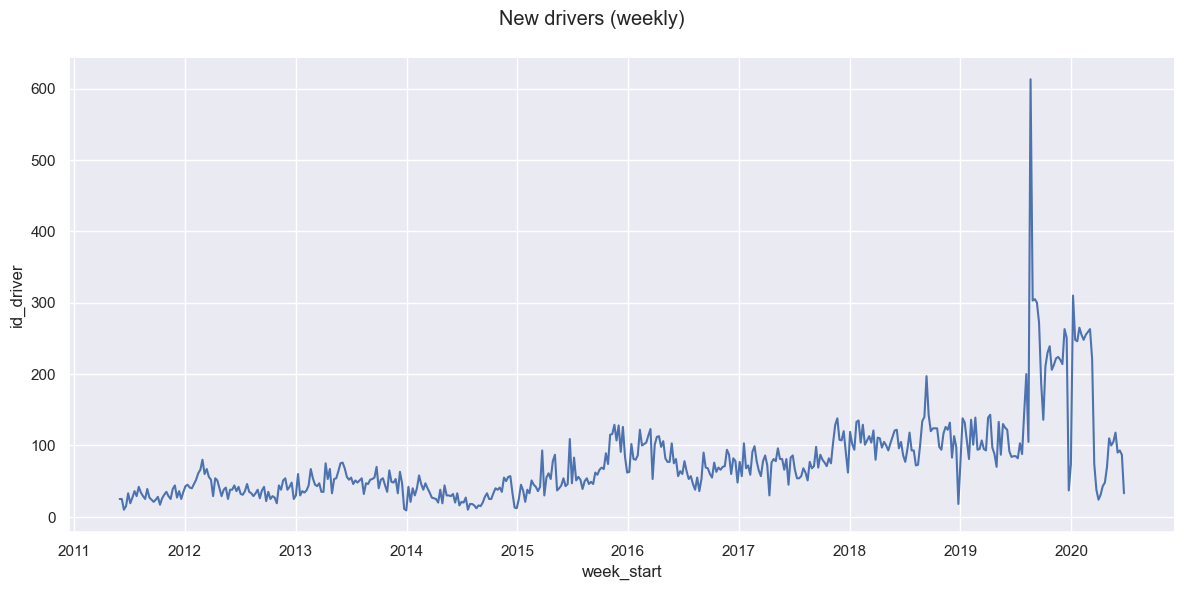

In [224]:
tmp = dr.groupby(['week_start']).agg({'id_driver': 'count'}).reset_index()

tmp = tmp.iloc[1:]

plt.figure(figsize=(10, 6))

facet = sns.relplot(
    data=tmp,
    x='week_start',
    y='id_driver',
    kind='line',
    height=6,
    aspect=2
)

facet.figure.subplots_adjust(top=.9)
facet.figure.suptitle(f'New drivers (weekly)')

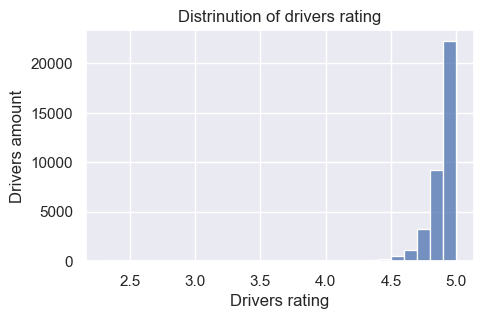

In [225]:
bins = [i / 10 for i in range(23, 51)]  

plt.figure(figsize=(5, 3))

sns.histplot(dr['driver_rating'], bins=bins, kde=False)

plt.title('Distrinution of drivers rating')
plt.xlabel('Drivers rating')
plt.ylabel('Drivers amount')
plt.show()


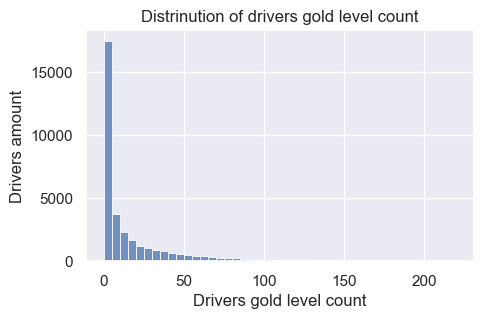

In [226]:
bins = [i for i in range(0, 224, 5)]  

plt.figure(figsize=(5, 3))

sns.histplot(dr['gold_level_count'], bins=bins, kde=False)

plt.title('Distrinution of drivers gold level count')
plt.xlabel('Drivers gold level count')
plt.ylabel('Drivers amount')
plt.show()


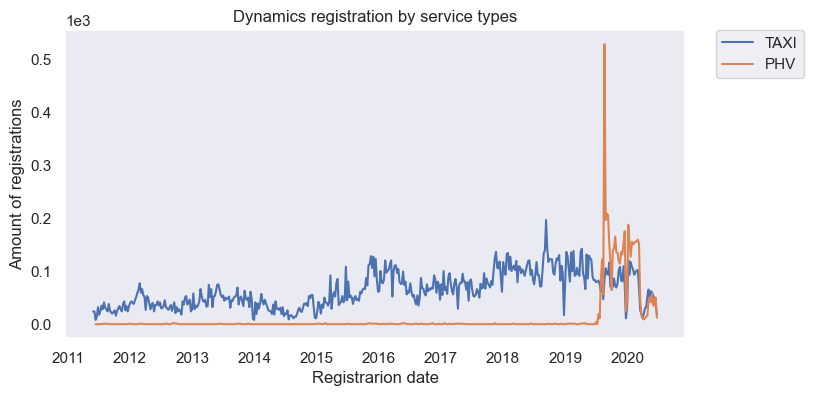

In [227]:
tmp = (
    dr[['week_start', 'service_type','id_driver']]
    .groupby(['week_start','service_type'])
    .agg(count=('id_driver', 'count'))
    .reset_index()
)

tmp = tmp.iloc[2:]

X = tmp['week_start']
types = tmp['service_type'].unique()  

plt.figure(figsize=(8, 4))

for type in types:
    subset = tmp[tmp['service_type'] == type]  
    sns.lineplot(x=subset['week_start'], y=subset['count'], label=f'{type}')  

plt.title('Dynamics registration by service types')
plt.xlabel('Registrarion date')
plt.ylabel('Amount of registrations')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.grid()
plt.show()

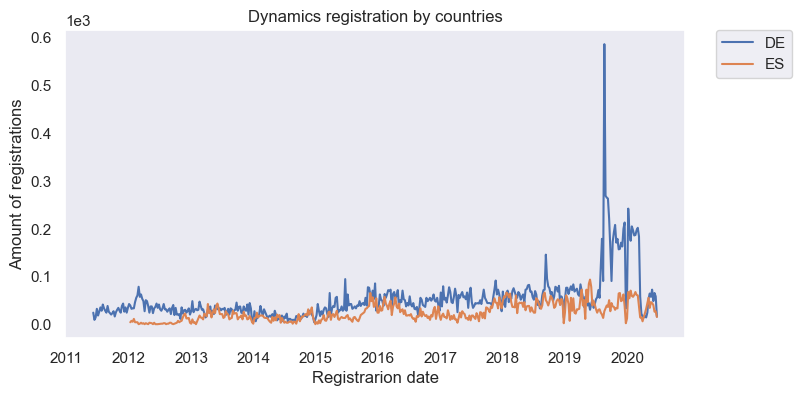

In [228]:
tmp = (
    dr[['week_start', 'country_code','id_driver']]
    .groupby(['week_start','country_code'])
    .agg(count=('id_driver', 'count'))
    .reset_index()
)

tmp = tmp.iloc[2:]

X = tmp['week_start']
types = tmp['country_code'].unique()  

plt.figure(figsize=(8, 4))

for type in types:
    subset = tmp[tmp['country_code'] == type]  
    sns.lineplot(x=subset['week_start'], y=subset['count'], label=f'{type}')  

plt.title('Dynamics registration by countries')
plt.xlabel('Registrarion date')
plt.ylabel('Amount of registrations')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.grid()
plt.show()

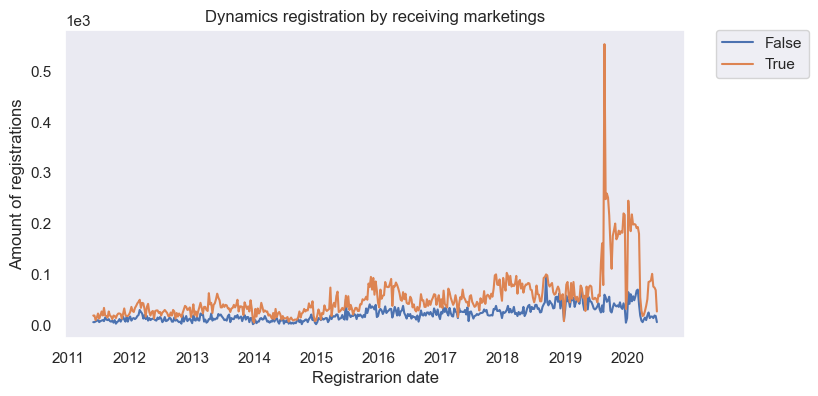

In [229]:
tmp = (
    dr[['week_start', 'receive_marketing','id_driver']]
    .groupby(['week_start','receive_marketing'])
    .agg(count=('id_driver', 'count'))
    .reset_index()
)

tmp = tmp.iloc[2:]

X = tmp['week_start']
types = tmp['receive_marketing'].unique()  

plt.figure(figsize=(8, 4))

for type in types:
    subset = tmp[tmp['receive_marketing'] == type]  
    sns.lineplot(x=subset['week_start'], y=subset['count'], label=f'{type}')   

plt.title('Dynamics registration by receiving marketings')
plt.xlabel('Registrarion date')
plt.ylabel('Amount of registrations')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.grid()
plt.show()

## Activities

In [230]:
primary_key = ['id_driver','active_date']
assert act.set_index(primary_key).index.is_unique, 'found duplicates'

In [231]:
act.describe()

,id_driver,active_date,offers,bookings,bookings_cancelled_by_passenger,bookings_cancelled_by_driver,rides,week_start,month_end
count,1.828412e+06,1828412,1.828412e+06,1.828412e+06,1.828412e+06,1.828412e+06,1.828412e+06,1828412,1828412
mean,2.741863e+07,2020-03-12 14:40:57.702529792,1.388124e+01,3.940352e+00,4.162475e-01,3.055340e-01,3.224467e+00,2020-03-09 16:41:15.627595008,2020-03-28 09:07:23.031001344
min,3.000000e+00,2020-01-01 00:00:00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2019-12-31 00:00:00,2020-01-31 00:00:00
25%,1.452799e+07,2020-01-30 00:00:00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2020-01-28 00:00:00,2020-01-31 00:00:00
50%,2.274422e+07,2020-02-26 00:00:00,7.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2020-02-25 00:00:00,2020-02-29 00:00:00
75%,4.919583e+07,2020-04-28 00:00:00,1.400000e+01,5.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,2020-04-28 00:00:00,2020-04-30 00:00:00
max,5.899682e+07,2020-06-30 00:00:00,2.558000e+03,7.400000e+01,3.800000e+01,5.500000e+01,4.600000e+01,2020-06-30 00:00:00,2020-07-31 00:00:00
std,1.864257e+07,NaN,3.001177e+01,3.753831e+00,8.609067e-01,8.038019e-01,3.039941e+00,NaN,NaN


In [232]:
tmp = (
    act[['week_start', 'id_driver','offers', 'bookings','bookings_cancelled_by_passenger','bookings_cancelled_by_driver','rides']] #
    .groupby(['week_start'])
    .agg(
        offers=('offers', 'sum'),
        bookings=('bookings', 'sum'),
        bookings_cancelled_by_passenger=('bookings_cancelled_by_passenger', 'sum'),
        bookings_cancelled_by_driver=('bookings_cancelled_by_driver', 'sum'),
        rides=('rides', 'sum')
    )
    .reset_index()
)

tmp['Acceptance rate'] = tmp['bookings'] / tmp['offers']
tmp['Done rate'] = tmp['rides'] / tmp['offers']
tmp['Pass cancel rate'] = tmp['bookings_cancelled_by_passenger'] / tmp['bookings']
tmp['Drivers cancel rate'] = tmp['bookings_cancelled_by_driver'] / tmp['bookings']

tmp.head()

,week_start,offers,bookings,bookings_cancelled_by_passenger,bookings_cancelled_by_driver,rides,Acceptance rate,Done rate,Pass cancel rate,Drivers cancel rate
0,2019-12-31,2622426,320890,38081,40780,242860,0.122364,0.092609,0.118673,0.127084
1,2020-01-07,1393231,420704,41414,29747,349927,0.301963,0.251162,0.098440,0.070708
2,2020-01-14,1892639,505909,50271,38015,418245,0.267303,0.220985,0.099368,0.075142
3,2020-01-21,2607392,547108,54712,45216,447994,0.209830,0.171817,0.100002,0.082645
4,2020-01-28,2336030,565213,58391,48083,459720,0.241955,0.196795,0.103308,0.085071


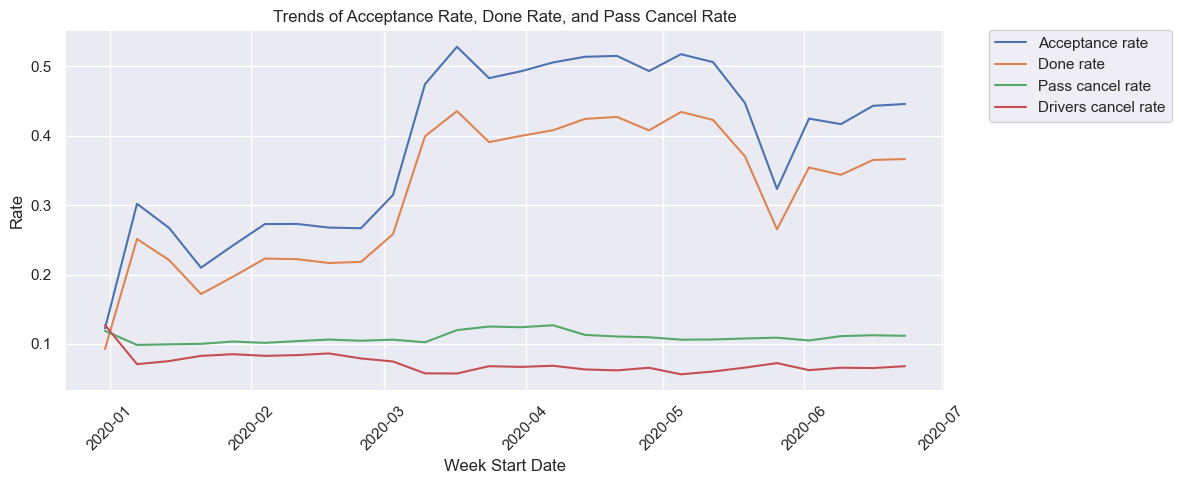

In [233]:
last_date = tmp['week_start'].max()

filtered_act = tmp[tmp['week_start'] != last_date]

plt.figure(figsize=(12, 5))

fields = ['Acceptance rate', 'Done rate', 'Pass cancel rate', 'Drivers cancel rate']

for field in fields:
    sns.lineplot(x=filtered_act['week_start'], y=filtered_act[field], label=field)

plt.title('Trends of Acceptance Rate, Done Rate, and Pass Cancel Rate')
plt.xlabel('Week Start Date')
plt.ylabel('Rate')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

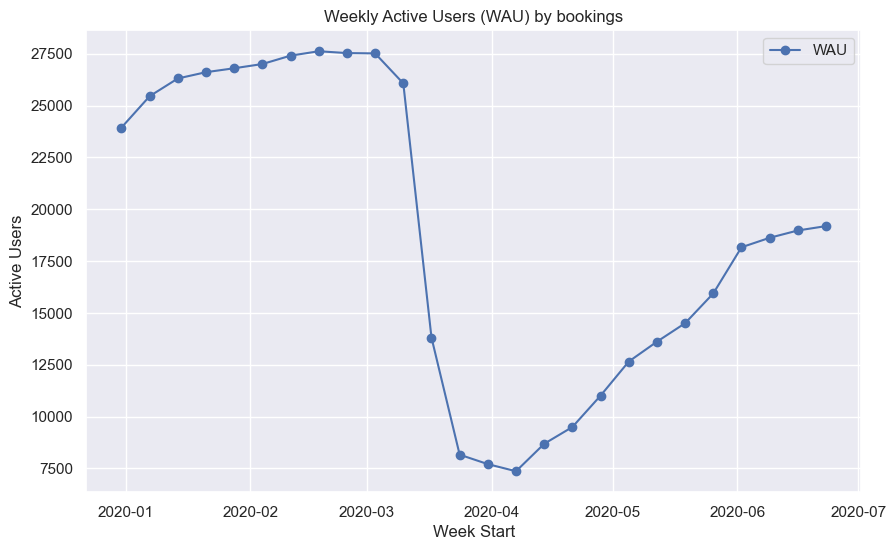

In [234]:
tmp = act[act['bookings'] > 0]

last_date = tmp['week_start'].max()

tmp = tmp[tmp['week_start'] != last_date]

wau = tmp.groupby('week_start')['id_driver'].nunique().reset_index()

wau.columns = ['week_start', 'weekly_active_users']

plt.figure(figsize=(10, 6))
plt.plot(wau['week_start'], wau['weekly_active_users'], marker='o', label='WAU')
plt.title('Weekly Active Users (WAU) by bookings')
plt.xlabel('Week Start')
plt.ylabel('Active Users')
plt.grid(True)
plt.legend()
plt.show()

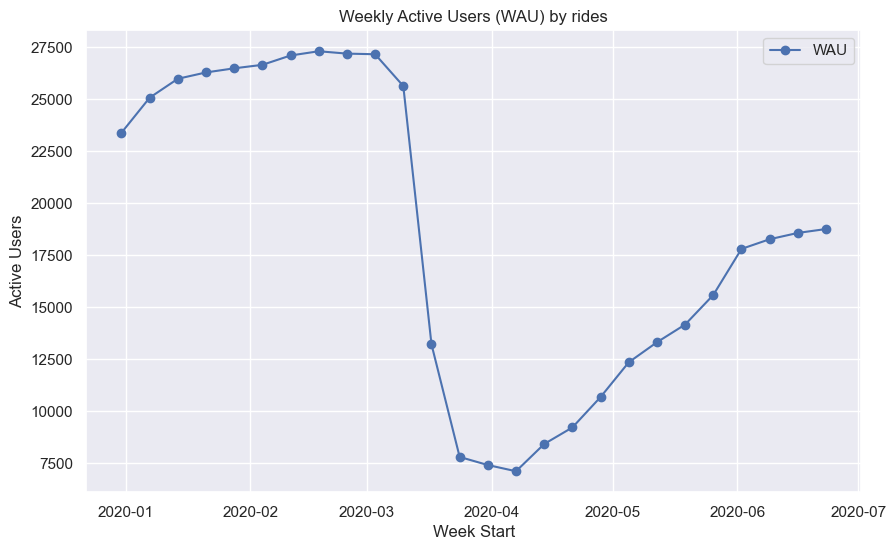

In [235]:
tmp = act[act['rides'] > 0]

wau = tmp.groupby('week_start')['id_driver'].nunique().reset_index()

wau.columns = ['week_start', 'weekly_active_users']

plt.figure(figsize=(10, 6))
plt.plot(wau['week_start'], wau['weekly_active_users'], marker='o', label='WAU')
plt.title('Weekly Active Users (WAU) by rides')
plt.xlabel('Week Start')
plt.ylabel('Active Users')
plt.grid(True)
plt.legend()
plt.show()

In [236]:
tmp = (
    act[['week_start','offers', 'bookings','rides']] #
    .groupby(['week_start'])
    .agg(
        offers_aggregated=('offers', 'sum'),
        bookings_aggregated=('bookings', 'sum'),
        rides_aggregated=('rides', 'sum')
    )
    .reset_index()
)

tmp.head()

,week_start,offers_aggregated,bookings_aggregated,rides_aggregated
0,2019-12-31,2622426,320890,242860
1,2020-01-07,1393231,420704,349927
2,2020-01-14,1892639,505909,418245
3,2020-01-21,2607392,547108,447994
4,2020-01-28,2336030,565213,459720


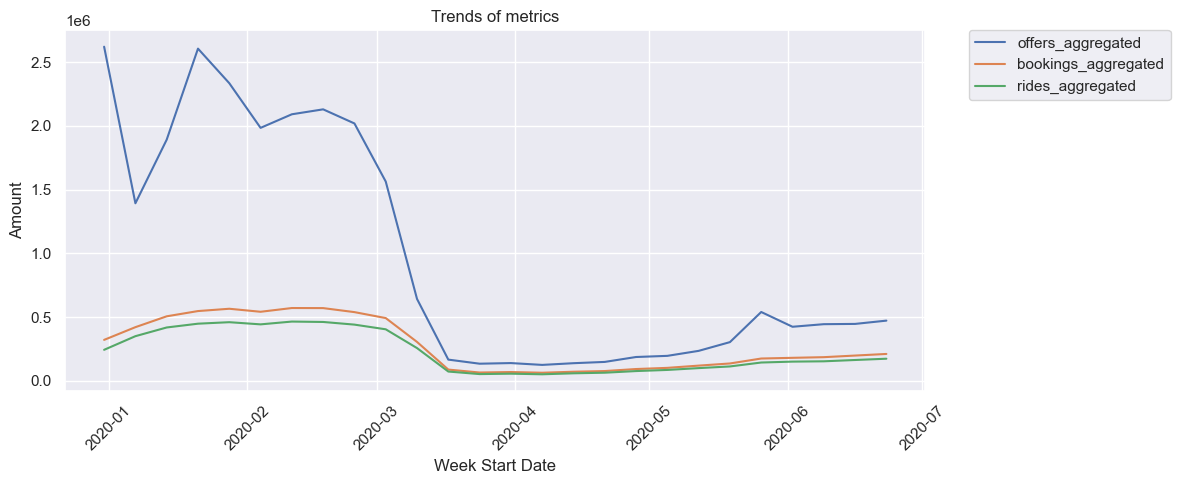

In [237]:
last_date = tmp['week_start'].max()

tmp = tmp[tmp['week_start'] != last_date]

plt.figure(figsize=(12, 5))

fields = ['offers_aggregated', 'bookings_aggregated', 'rides_aggregated']

for field in fields:
    sns.lineplot(x=tmp['week_start'], y=tmp[field], label=field)

plt.title('Trends of metrics')
plt.xlabel('Week Start Date')
plt.ylabel('Amount')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [238]:
tmp = (
    act[['id_driver','week_start','offers', 'bookings','rides']] #
    .groupby(['id_driver','week_start'])
    .agg(
        offers_per_driver=('offers', 'mean'),
        bookings_per_driver=('bookings', 'mean'),
        rides_per_driver=('rides', 'mean')
    )
    .reset_index()
)

tmp.head()

,id_driver,week_start,offers_per_driver,bookings_per_driver,rides_per_driver
0,3,2019-12-31,13.500000,5.166667,3.666667
1,3,2020-01-07,6.333333,4.833333,3.500000
2,3,2020-01-14,10.200000,6.000000,5.000000
3,3,2020-01-21,6.000000,4.142857,3.285714
4,3,2020-01-28,10.600000,7.000000,5.200000


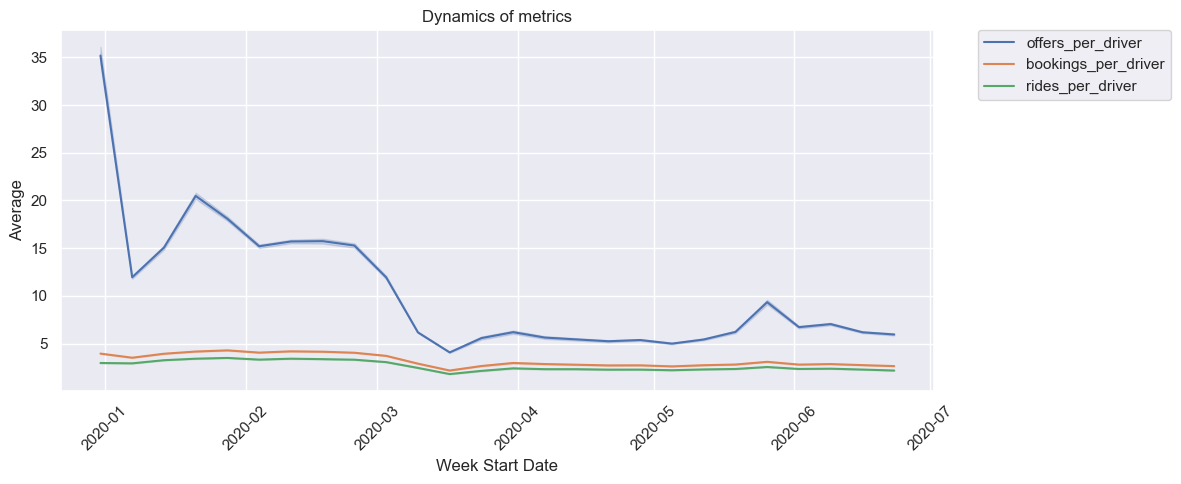

In [239]:
last_date = tmp['week_start'].max()

tmp = tmp[tmp['week_start'] != last_date]

plt.figure(figsize=(12, 5))

fields = ['offers_per_driver', 'bookings_per_driver', 'rides_per_driver']

for field in fields:
    sns.lineplot(x=tmp['week_start'], y=tmp[field], label=field)

plt.title('Dynamics of metrics')
plt.xlabel('Week Start Date')
plt.ylabel('Average')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Data Insights

## Key metrics

### Key metrics trends, insights

1. We have an acquisition boost from the middle of 2019 till the beggining of 2020 in DE.
2. We observed a significant driver outflow starting from mid-March, followed by a gradual recovery.
3. We also observed a significant drop in orders during the same period, followed by a gradual recovery.
4. Due to the aforementioned reasons, we have seen a significant increase in the acceptance and done rates, while the share of driver cancellations has decreased significantly.
5. We had a very low order fulfillment rate. Only 20% of the orders created by customers were able to be fulfilled before the significant driver outflow.

In [240]:
df = pd.merge(
    act,
    dr,
    on='id_driver',
    how='inner' #no empty values
)

df.rename(columns={'week_start_x': 'week_start_act', 'week_start_y': 'week_start_dr'}, inplace=True)

df.head()

,id_driver,active_date,offers,bookings,bookings_cancelled_by_passenger,bookings_cancelled_by_driver,rides,week_start_act,month_end,date_registration,driver_rating,gold_level_count,receive_marketing,country_code,service_type,week_start_dr
0,3,2020-01-01,65,18,3,4,11,2019-12-31,2020-01-31,2011-05-29,4.87,22.0,True,DE,TAXI,2011-05-24
1,3,2020-01-02,3,2,0,1,1,2019-12-31,2020-01-31,2011-05-29,4.87,22.0,True,DE,TAXI,2011-05-24
2,3,2020-01-03,1,1,0,0,1,2019-12-31,2020-01-31,2011-05-29,4.87,22.0,True,DE,TAXI,2011-05-24
3,3,2020-01-04,3,4,0,0,4,2019-12-31,2020-01-31,2011-05-29,4.87,22.0,True,DE,TAXI,2011-05-24
4,3,2020-01-05,6,4,0,1,3,2019-12-31,2020-01-31,2011-05-29,4.87,22.0,True,DE,TAXI,2011-05-24


#### Drivers WAU

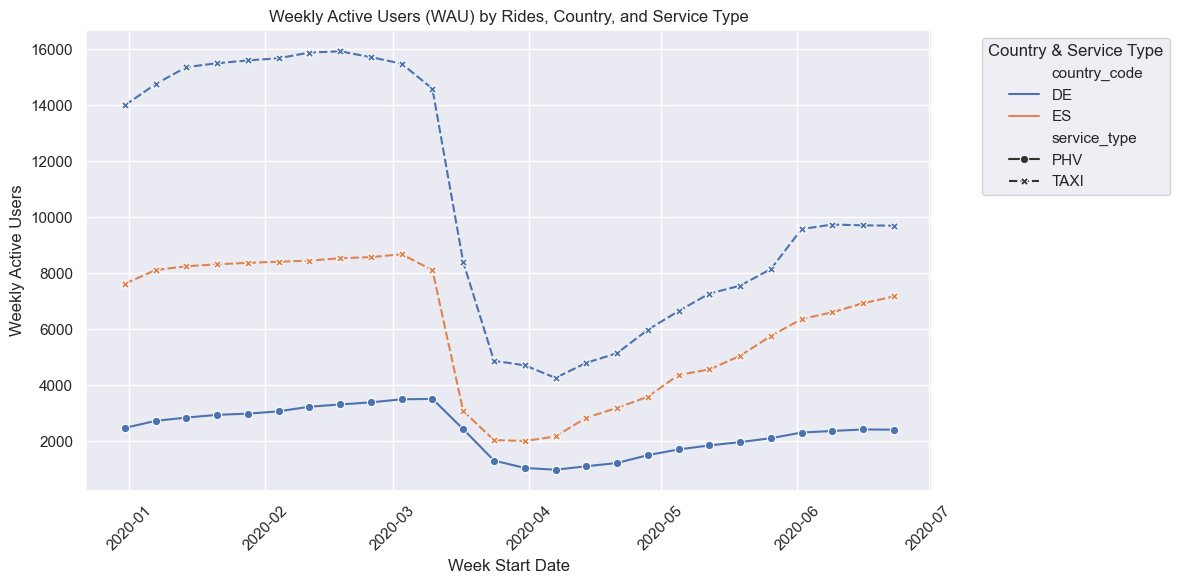

In [241]:
wau = df.groupby(['week_start_act', 'country_code', 'service_type'])['id_driver'].nunique().reset_index()
wau.columns = ['week_start_act', 'country_code', 'service_type', 'weekly_active_users']

last_date = wau['week_start_act'].max()
wau = wau[wau['week_start_act'] != last_date]

plt.figure(figsize=(12, 6))

sns.lineplot(data=wau, x='week_start_act', y='weekly_active_users', hue='country_code', style='service_type', markers=True)

plt.title('Weekly Active Users (WAU) by Rides, Country, and Service Type')
plt.xlabel('Week Start Date')
plt.ylabel('Weekly Active Users')

plt.xticks(rotation=45)

plt.grid(True)
plt.legend(title="Country & Service Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

#### DAU/MAU Ratio

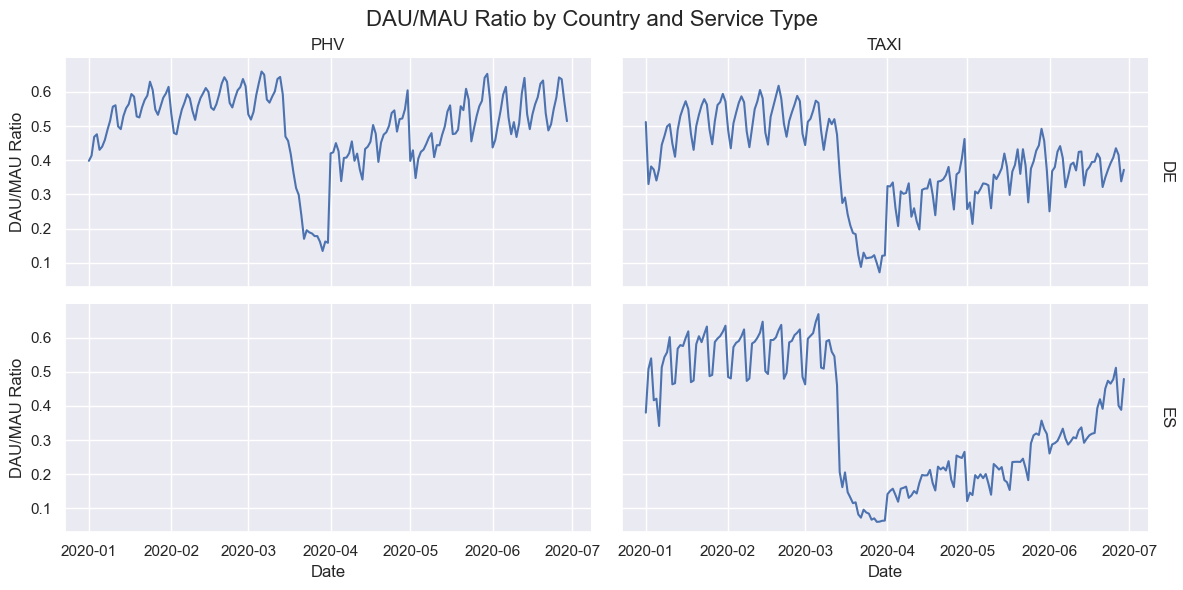

In [242]:
df['month_end'] = df['active_date'].dt.to_period('M')

dau = df.groupby(['active_date', 'country_code', 'service_type'])['id_driver'].nunique().reset_index()
dau.columns = ['date', 'country_code', 'service_type', 'DAU']

last_date = dau['date'].max()
dau = dau[dau['date'] != last_date]

mau = df.groupby(['month_end', 'country_code', 'service_type'])['id_driver'].nunique().reset_index()
mau.columns = ['month_end', 'country_code', 'service_type', 'MAU']

dau['month_end'] = dau['date'].dt.to_period('M')
dau = dau.merge(mau, on=['month_end', 'country_code', 'service_type'], how='left')

dau['DAU_MAU_Ratio'] = dau['DAU'] / dau['MAU']

g2 = sns.FacetGrid(dau, row="country_code", col="service_type", margin_titles=True, height=3, aspect=2)
g2.map(sns.lineplot, "date", "DAU_MAU_Ratio")
g2.set_axis_labels("Date", "DAU/MAU Ratio")
g2.set_titles(row_template="{row_name}", col_template="{col_name}")
g2.fig.subplots_adjust(top=0.9)
g2.fig.suptitle("DAU/MAU Ratio by Country and Service Type", fontsize=16)

plt.show()

#### Drivers retention

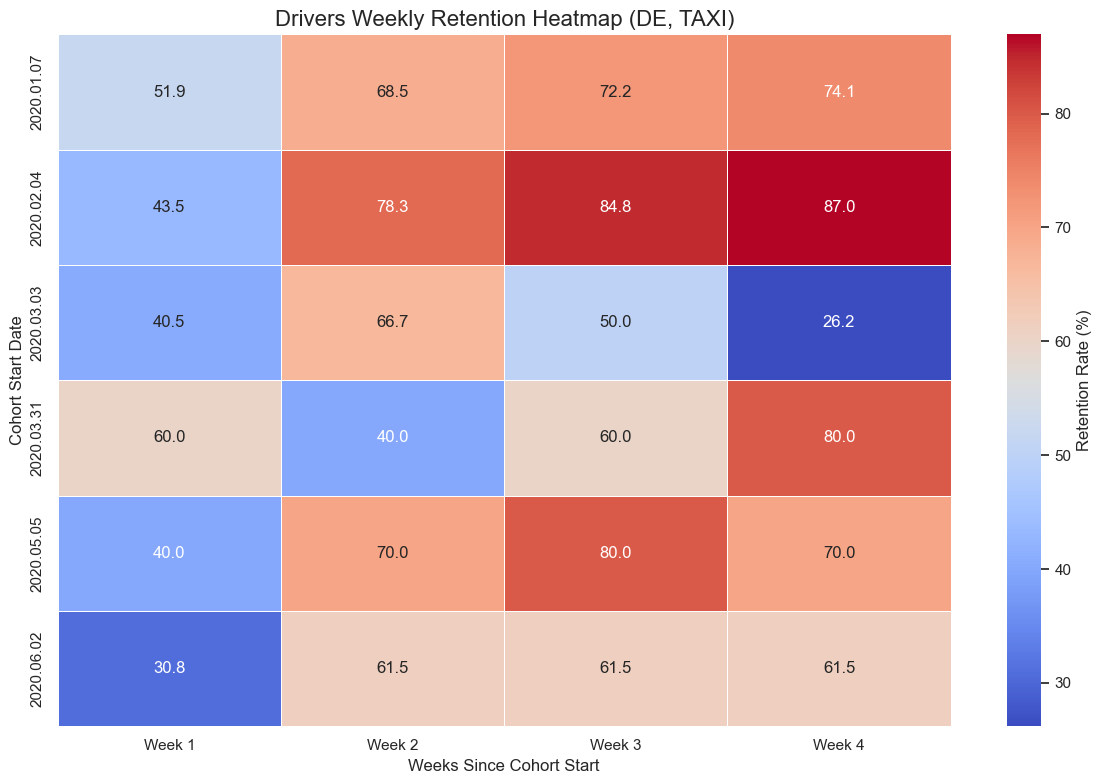

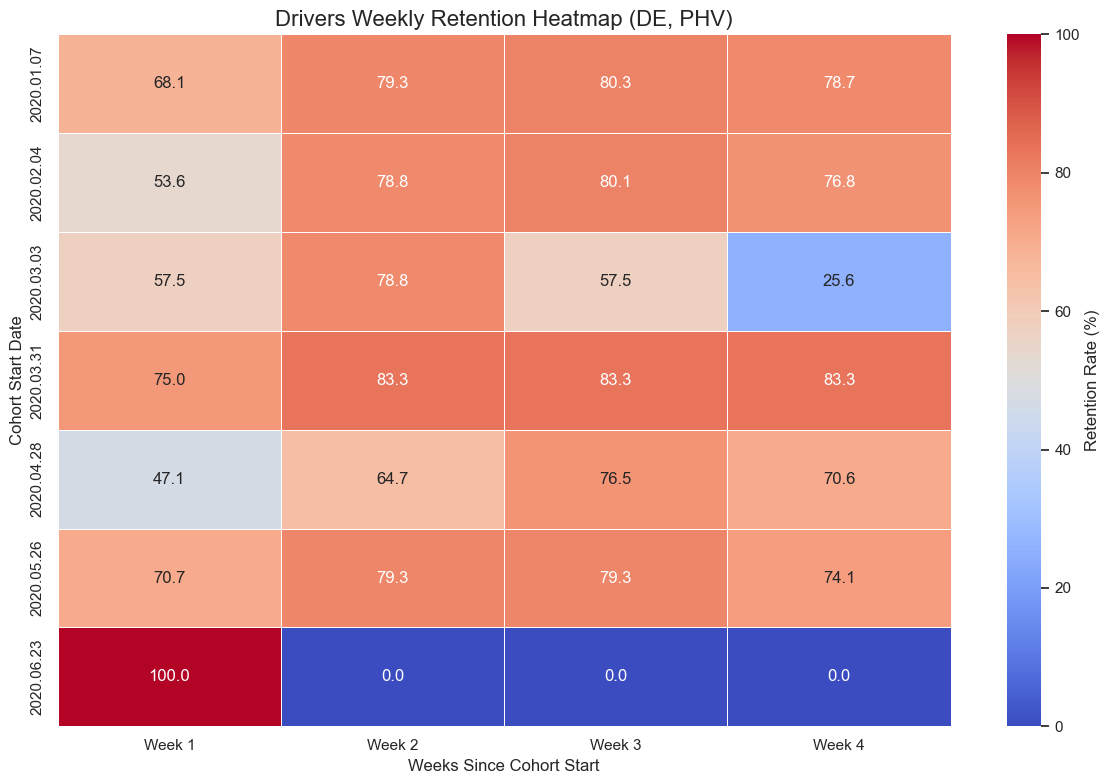

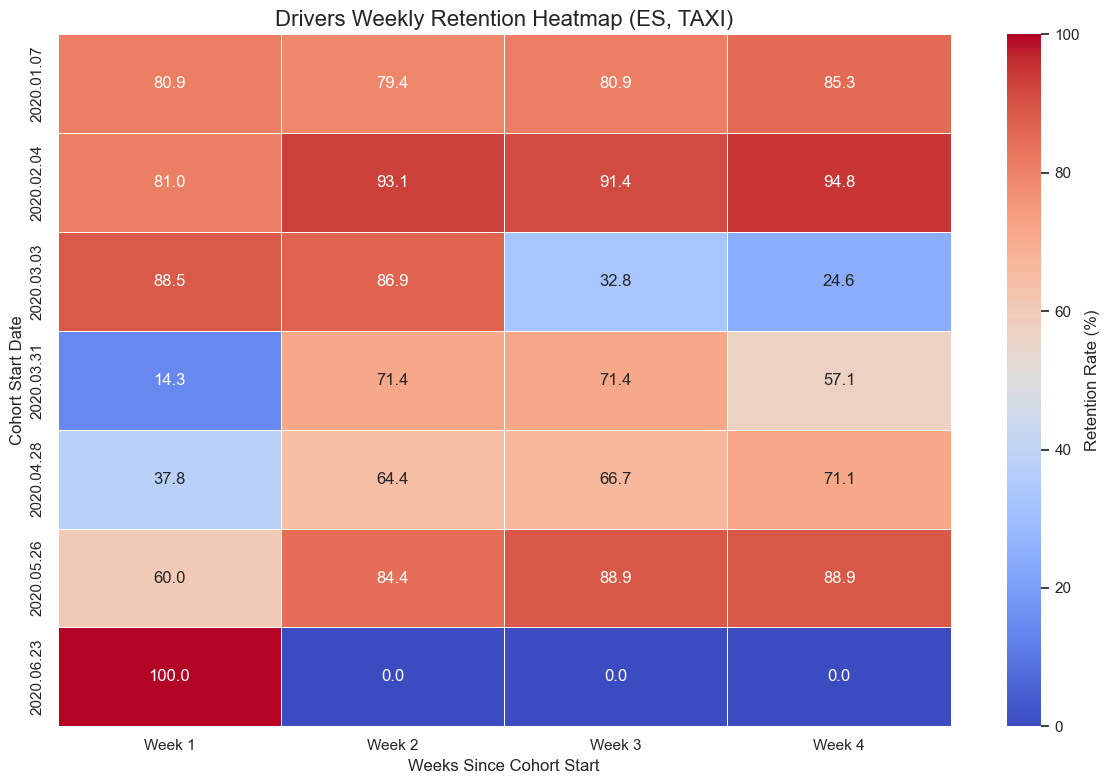

In [243]:
tmp = df[df['week_start_dr'] >= '2020-01-01']

combinations = tmp[['country_code', 'service_type']].drop_duplicates()

weeks_to_display = [1, 2, 3, 4]

for _, combination in combinations.iterrows():
    country = combination['country_code']
    service = combination['service_type']
    
    subset = tmp[(tmp['country_code'] == country) & (tmp['service_type'] == service)]
    
    cohorts = subset.groupby('week_start_dr')['id_driver'].unique().reset_index()
    
    heatmap_data = []

    for i, row in cohorts.iterrows():
        start_date = row['week_start_dr']  
        drivers = set(row['id_driver'])
        
        weekly_retention = []
        for week in weeks_to_display:
            week_start = start_date + pd.Timedelta(days=(week - 1) * 7)
            week_end = week_start + pd.Timedelta(days=6)
            active_drivers = set(subset[(subset['active_date'] >= week_start) & (subset['active_date'] <= week_end)]['id_driver'])
            retention_rate = len(active_drivers & drivers) / len(drivers) * 100
            weekly_retention.append(retention_rate)
        
        heatmap_data.append(pd.Series(weekly_retention, name=start_date))

    heatmap_data = pd.concat(heatmap_data, axis=1).T
    heatmap_data.columns = [f"Week {week}" for week in weeks_to_display]
    heatmap_data.index.name = "Cohort Start Date"

    filtered_heatmap_data = heatmap_data.iloc[::4]

    filtered_heatmap_data = filtered_heatmap_data.dropna(how='all')

    filtered_heatmap_data = filtered_heatmap_data[filtered_heatmap_data.index <= pd.Timestamp("2024-06-01")]

    filtered_heatmap_data.index = filtered_heatmap_data.index.strftime("%Y.%m.%d")

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        filtered_heatmap_data, 
        annot=True,  
        fmt=".1f",   
        cmap="coolwarm", 
        linewidths=0.5, 
        cbar_kws={'label': 'Retention Rate (%)'}
    )
    plt.title(f"Drivers Weekly Retention Heatmap ({country}, {service})", fontsize=16)
    plt.xlabel("Weeks Since Cohort Start", fontsize=12)
    plt.ylabel("Cohort Start Date", fontsize=12)
    plt.tight_layout()
    plt.show()

#### Bookings and rides per drivers

<Figure size 1200x800 with 0 Axes>

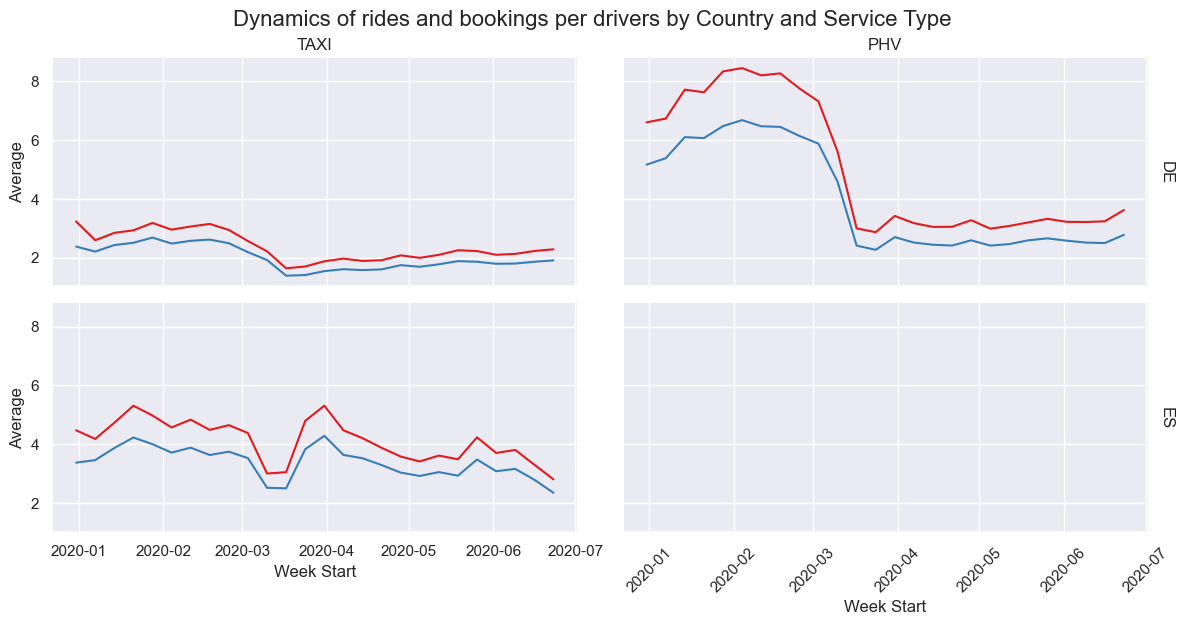

In [244]:
tmp = (
    df[['id_driver', 'week_start_act', 'bookings', 'rides', 'country_code', 'service_type']]
    .groupby(['id_driver', 'week_start_act', 'country_code', 'service_type'])
    .agg(
        bookings_per_driver=('bookings', 'mean'),
        rides_per_driver=('rides', 'mean')
    )
    .reset_index()
)

last_date = tmp['week_start_act'].max()
tmp = tmp[tmp['week_start_act'] != last_date]

plt.figure(figsize=(12, 8))

g = sns.FacetGrid(tmp, row="country_code", col="service_type", margin_titles=True, height=3, aspect=2)

palette = sns.color_palette("Set1", 2)  

fields = ['bookings_per_driver', 'rides_per_driver']
for i, field in enumerate(fields):
    g.map(sns.lineplot, "week_start_act", field, ci=None, color=palette[i])

g.set_axis_labels("Week Start", "Average")
g.set_titles(row_template="{row_name}", col_template="{col_name}")

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Dynamics of rides and bookings per drivers by Country and Service Type', fontsize=16)

plt.xticks(rotation=45)

plt.show()

#### Acceptence rate

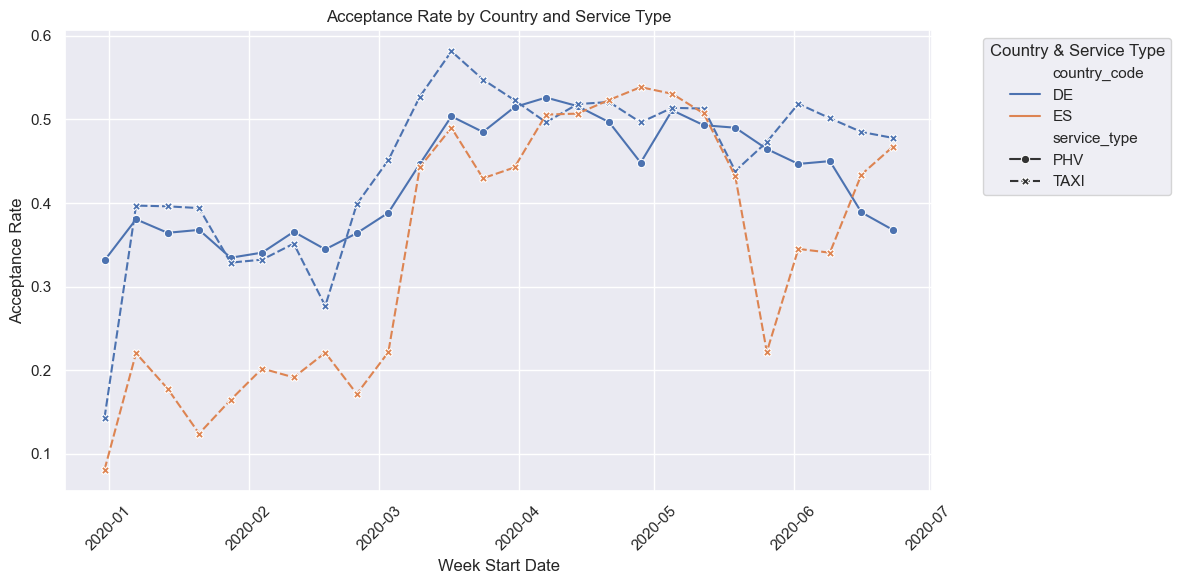

In [245]:
tmp = (
    df[['week_start_act', 'id_driver', 'offers', 'bookings', 'country_code', 'service_type']]
    .groupby(['week_start_act', 'country_code', 'service_type'])
    .agg(
        offers=('offers', 'sum'),
        bookings=('bookings', 'sum')
    )
    .reset_index()
)

tmp['Acceptance rate'] = tmp['bookings'] / tmp['offers']

last_date = tmp['week_start_act'].max()
filtered_act = tmp[tmp['week_start_act'] != last_date]

plt.figure(figsize=(12, 6))

sns.lineplot(data=filtered_act, x='week_start_act', y='Acceptance rate', hue='country_code', style='service_type', markers=True)

plt.title('Acceptance Rate by Country and Service Type')
plt.xlabel('Week Start Date')
plt.ylabel('Acceptance Rate')

plt.xticks(rotation=45)

plt.grid(True)
plt.legend(title="Country & Service Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Key insights and recomendations

1. The performance of the company's drivers has not recovered to pre-pandemic levels. Among other possible reasons, the emergence of competitors in these two countries could be a factor, as they have taken some of our traffic, leading to a significant decrease in orders.
2. Some drivers make trips even without receiving offers from the taxi service.
3. The highest unsatisfied demand occurs on weekends, with a peak on Sunday.
4. Orders have declined more significantly than other metrics. It's possible that the order allocation algorithm has changed. 
5. PHV drivers demonstrate better performance metrics. This could be because they stay online for longer periods or perhaps they primarily work during high supply hours.
6. The high driver acquisition rate in Germany around early 2020 can be explained by the introduction of the PHV driver type, which was likely accompanied by an extensive marketing campaign.
7. The factor indicating better performance from the company's perspective is the presence of the Private Hire Vehicle (PHV) category in the country. In Germany (DE), where PHV exists, the done_rate was higher compared to Spain (ES) before the pandemic. After the pandemic, it remained more stable in DE compared to ES.
8. The factor indicating the potential for improving driver performance is subscription to advertising. Drivers who subscribe to company advertising offers, on average, complete up to 50% more rides than those without the subscription.
9. After the lockdown announcement, the most loyal users, with over a year of experience on the platform, are now receiving more orders compared to new users. They have consistently improved their performance and experienced less significant declines during the lockdown compared to newcomers.
10. Service improvement suggestions:

    - Introduce the Private Hire Vehicle (PHV) format in Spain (ES).
    - Carefully inform users that those who subscribe to advertising offers are likely to get more deals since they are more familiar with the service and better utilize its features.
    - Research driver retention: The platform has a core audience of drivers who consistently use the service. Understanding why they do so and sharing these benefits with new drivers could improve overall retention.
    - It's necessary to review the offer distribution algorithms.
    - It is necessary to conduct tests with marketing activities aimed at attracting additional drivers on weekends.
    - It is necessary to investigate in detail the reasons behind the high performance of PHV drivers.
    - It is necessary to check for the presence of fraudulent drivers who are completing rides without receiving orders through the app.

P.S. To validate these conclusions, further research is needed, as the current data volume is limited.

In [246]:
df = pd.merge(
    act,
    dr,
    on='id_driver',
    how='inner' #no empty values
)

df.rename(columns={'week_start_x': 'week_start_act', 'week_start_y': 'week_start_dr'}, inplace=True)

df.head()

,id_driver,active_date,offers,bookings,bookings_cancelled_by_passenger,bookings_cancelled_by_driver,rides,week_start_act,month_end,date_registration,driver_rating,gold_level_count,receive_marketing,country_code,service_type,week_start_dr
0,3,2020-01-01,65,18,3,4,11,2019-12-31,2020-01-31,2011-05-29,4.87,22.0,True,DE,TAXI,2011-05-24
1,3,2020-01-02,3,2,0,1,1,2019-12-31,2020-01-31,2011-05-29,4.87,22.0,True,DE,TAXI,2011-05-24
2,3,2020-01-03,1,1,0,0,1,2019-12-31,2020-01-31,2011-05-29,4.87,22.0,True,DE,TAXI,2011-05-24
3,3,2020-01-04,3,4,0,0,4,2019-12-31,2020-01-31,2011-05-29,4.87,22.0,True,DE,TAXI,2011-05-24
4,3,2020-01-05,6,4,0,1,3,2019-12-31,2020-01-31,2011-05-29,4.87,22.0,True,DE,TAXI,2011-05-24


In [247]:
df.describe()

,id_driver,active_date,offers,bookings,bookings_cancelled_by_passenger,bookings_cancelled_by_driver,rides,week_start_act,month_end,date_registration,driver_rating,gold_level_count,week_start_dr
count,1.840777e+06,1840777,1.840777e+06,1.840777e+06,1.840777e+06,1.840777e+06,1.840777e+06,1840777,1840777,1840777,1.840620e+06,1.735828e+06,1840777
mean,2.746008e+07,2020-03-12 14:51:53.002388992,1.388833e+01,3.955017e+00,4.192550e-01,3.066254e-01,3.235111e+00,2020-03-09 16:51:53.420907264,2020-03-28 09:18:51.297707264,2016-12-27 09:34:19.893403648,4.894746e+00,2.354597e+01,2016-12-25 04:57:19.091210752
min,3.000000e+00,2020-01-01 00:00:00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2019-12-31 00:00:00,2020-01-31 00:00:00,2011-05-29 00:00:00,2.330000e+00,0.000000e+00,2011-05-24 00:00:00
25%,1.453013e+07,2020-01-30 00:00:00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2020-01-28 00:00:00,2020-01-31 00:00:00,2015-04-29 00:00:00,4.860000e+00,1.000000e+00,2015-04-28 00:00:00
50%,2.281504e+07,2020-02-26 00:00:00,7.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2020-02-25 00:00:00,2020-02-29 00:00:00,2017-08-15 00:00:00,4.920000e+00,1.000000e+01,2017-08-15 00:00:00
75%,4.932457e+07,2020-04-28 00:00:00,1.400000e+01,5.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,2020-04-28 00:00:00,2020-04-30 00:00:00,2019-04-30 00:00:00,4.960000e+00,3.400000e+01,2019-04-30 00:00:00
max,5.899682e+07,2020-06-30 00:00:00,2.558000e+03,7.400000e+01,3.800000e+01,5.500000e+01,4.600000e+01,2020-06-30 00:00:00,2020-07-31 00:00:00,2020-06-27 00:00:00,5.000000e+00,2.240000e+02,2020-06-23 00:00:00
std,1.866810e+07,NaN,2.999394e+01,3.784401e+00,8.690908e-01,8.068765e-01,3.060200e+00,NaN,NaN,NaN,9.873079e-02,3.130132e+01,NaN


In [248]:
df['days_since_registration'] = (df['active_date'] - df['date_registration']).dt.days

def cohort_category(days):
    if days < 30:
        return '< 1 month'
    elif 30 <= days < 90:
        return '1 - 3 months'
    elif 90 <= days < 365:
        return '3 months - 1 year'
    elif 365 <= days < 1095:
        return '1 - 3 years'
    else:
        return '> 3 years'

df['registration_cohort'] = df['days_since_registration'].apply(cohort_category)
df.drop(columns=['days_since_registration'], inplace=True)

df[['id_driver', 'active_date', 'date_registration', 'registration_cohort']].head()

,id_driver,active_date,date_registration,registration_cohort
0,3,2020-01-01,2011-05-29,> 3 years
1,3,2020-01-02,2011-05-29,> 3 years
2,3,2020-01-03,2011-05-29,> 3 years
3,3,2020-01-04,2011-05-29,> 3 years
4,3,2020-01-05,2011-05-29,> 3 years


#### Performance by drivers cohots

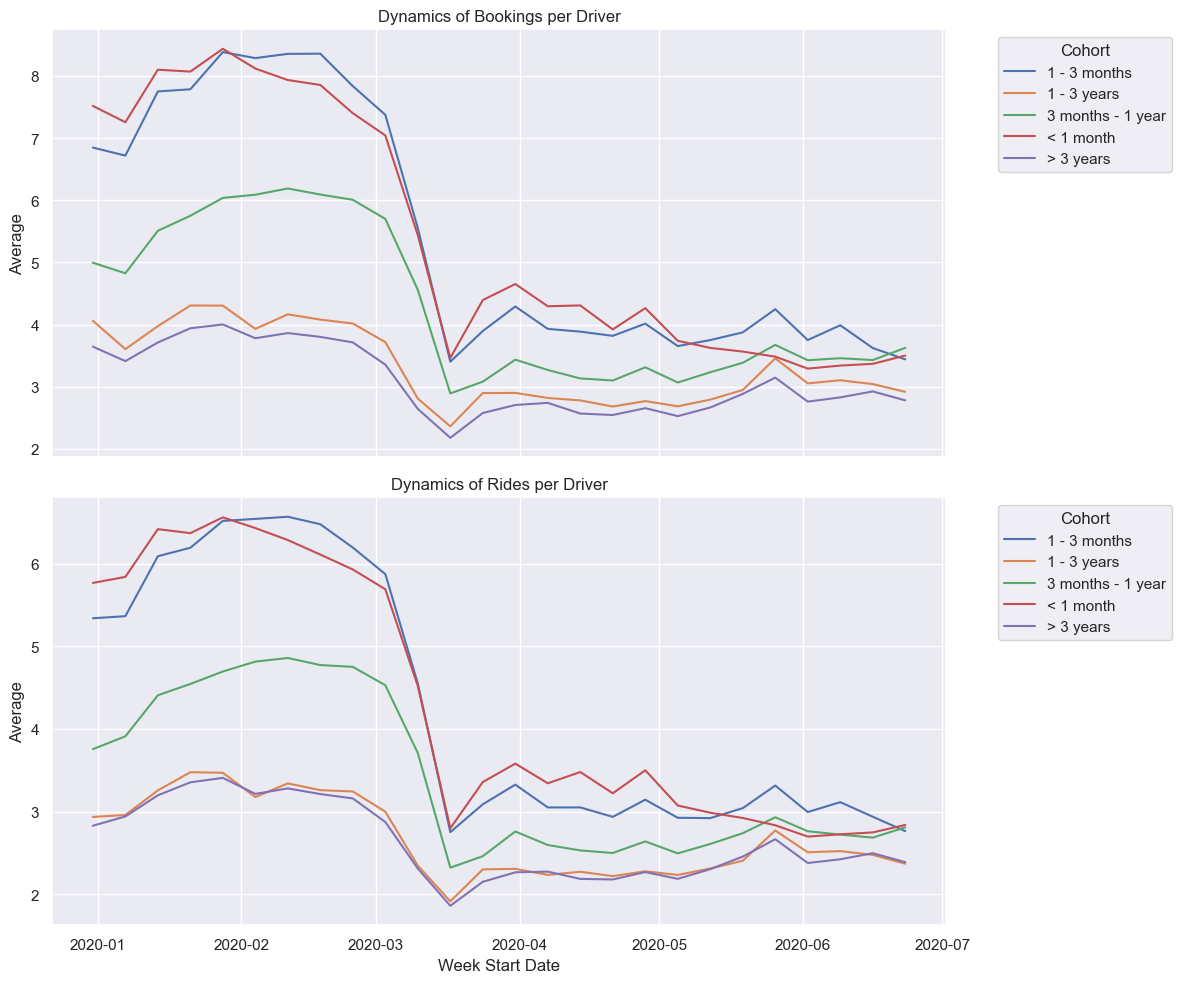

In [249]:
tmp = (
    df[['id_driver', 'week_start_act', 'bookings', 'rides', 'registration_cohort']]
    .groupby(['week_start_act', 'registration_cohort'])
    .agg(
        bookings_per_driver=('bookings', 'mean'),
        rides_per_driver=('rides', 'mean')
    )
    .reset_index()
)

last_date = tmp['week_start_act'].max()
tmp = tmp[tmp['week_start_act'] != last_date]

fields = ['bookings_per_driver', 'rides_per_driver']
titles = ['Dynamics of Bookings per Driver', 'Dynamics of Rides per Driver']

fig, axes = plt.subplots(len(fields), 1, figsize=(12, 10), sharex=True)

for i, field in enumerate(fields):
    ax = axes[i]
    sns.lineplot(
        data=tmp,
        x='week_start_act',
        y=field,
        hue='registration_cohort',
        ax=ax
    )
    ax.set_title(titles[i])
    ax.set_xlabel('Week Start Date' if i == len(fields) - 1 else '')
    ax.set_ylabel('Average')
    ax.grid(True)
    ax.legend(title='Cohort', loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

#### Acceptance rate using cohort analysis

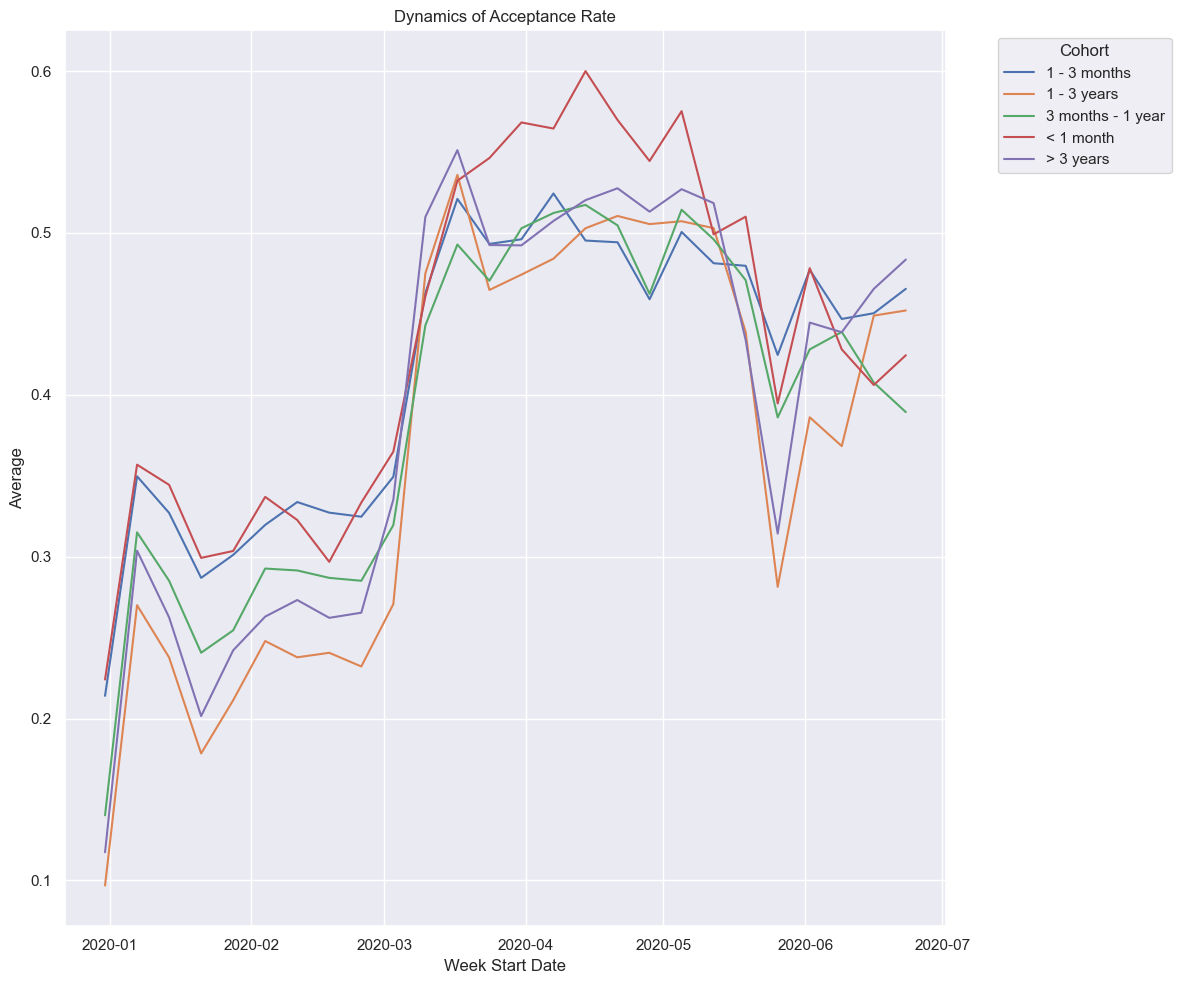

In [250]:
tmp = (
    df[['id_driver', 'week_start_act', 'bookings', 'offers', 'registration_cohort']]
    .groupby(['week_start_act', 'registration_cohort'])
    .agg(
        bookings=('bookings', 'sum'),
        offers=('offers', 'sum')
    )
    .reset_index()
)

last_date = tmp['week_start_act'].max()
tmp = tmp[tmp['week_start_act'] != last_date]

tmp['acceptence_rate'] = tmp['bookings'] / tmp['offers']

fields = ['acceptence_rate']
titles = ['Dynamics of Acceptance Rate']

fig, axes = plt.subplots(len(fields), 1, figsize=(12, 10), sharex=True)

if len(fields) == 1:
    axes = [axes]

for i, field in enumerate(fields):
    ax = axes[i]
    sns.lineplot(
        data=tmp,
        x='week_start_act',
        y=field,
        hue='registration_cohort',
        ax=ax
    )
    ax.set_title(titles[i])
    ax.set_xlabel('Week Start Date' if i == len(fields) - 1 else '')
    ax.set_ylabel('Average')
    ax.grid(True)
    ax.legend(title='Cohort', loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

#### RFM

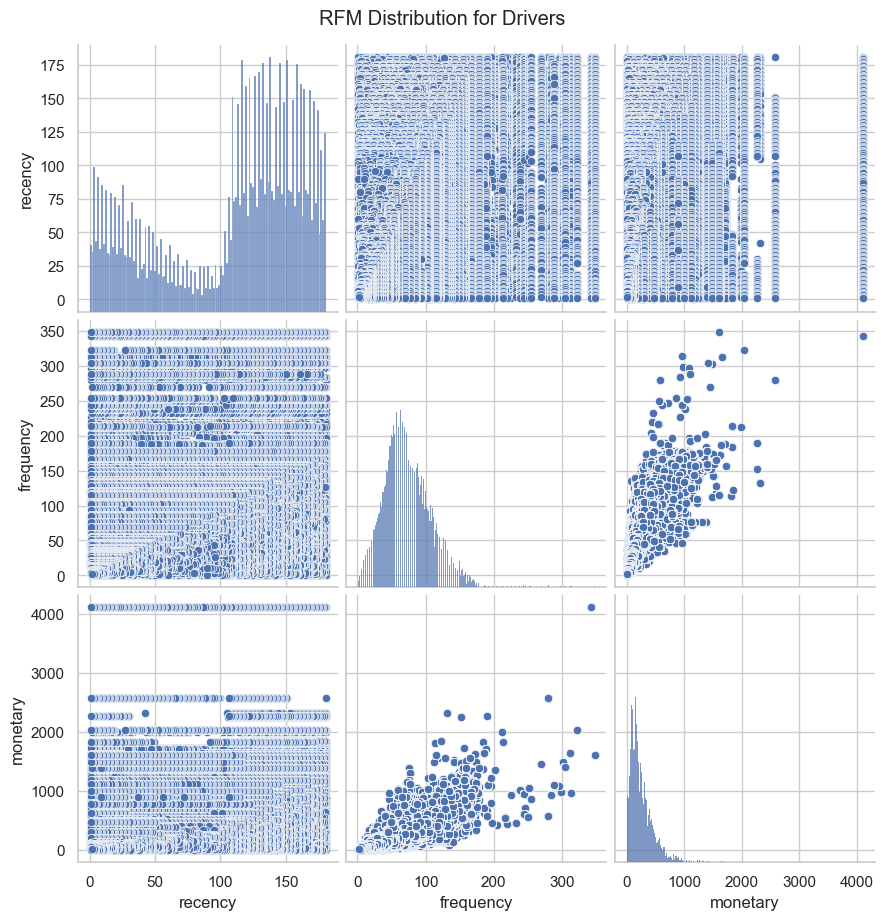

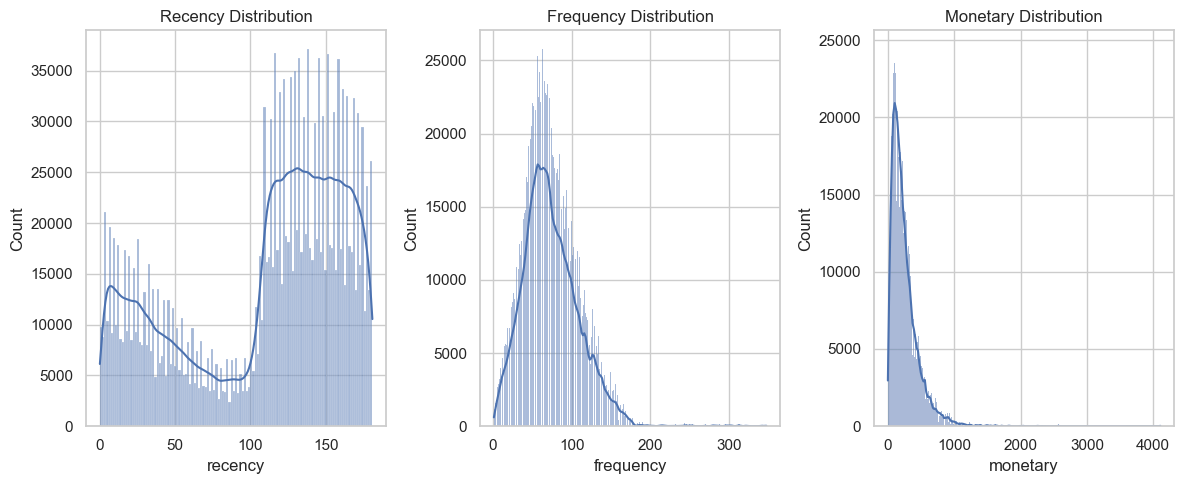

In [251]:
latest_date = df['active_date'].max()
df['recency'] = (latest_date - df['active_date']).dt.days

frequency = df.groupby('id_driver')['bookings'].count().reset_index()
frequency.columns = ['id_driver', 'frequency']

monetary = df.groupby('id_driver')['rides'].sum().reset_index()
monetary.columns = ['id_driver', 'monetary']

rfm = pd.merge(frequency, monetary, on='id_driver')
rfm = pd.merge(rfm, df[['id_driver', 'recency']].drop_duplicates(), on='id_driver')

sns.set(style="whitegrid")

sns.pairplot(rfm, vars=["recency", "frequency", "monetary"], height=3)
plt.suptitle('RFM Distribution for Drivers', y=1.02)
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm['recency'], kde=True)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm['frequency'], kde=True)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm['monetary'], kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

#### Product funnels

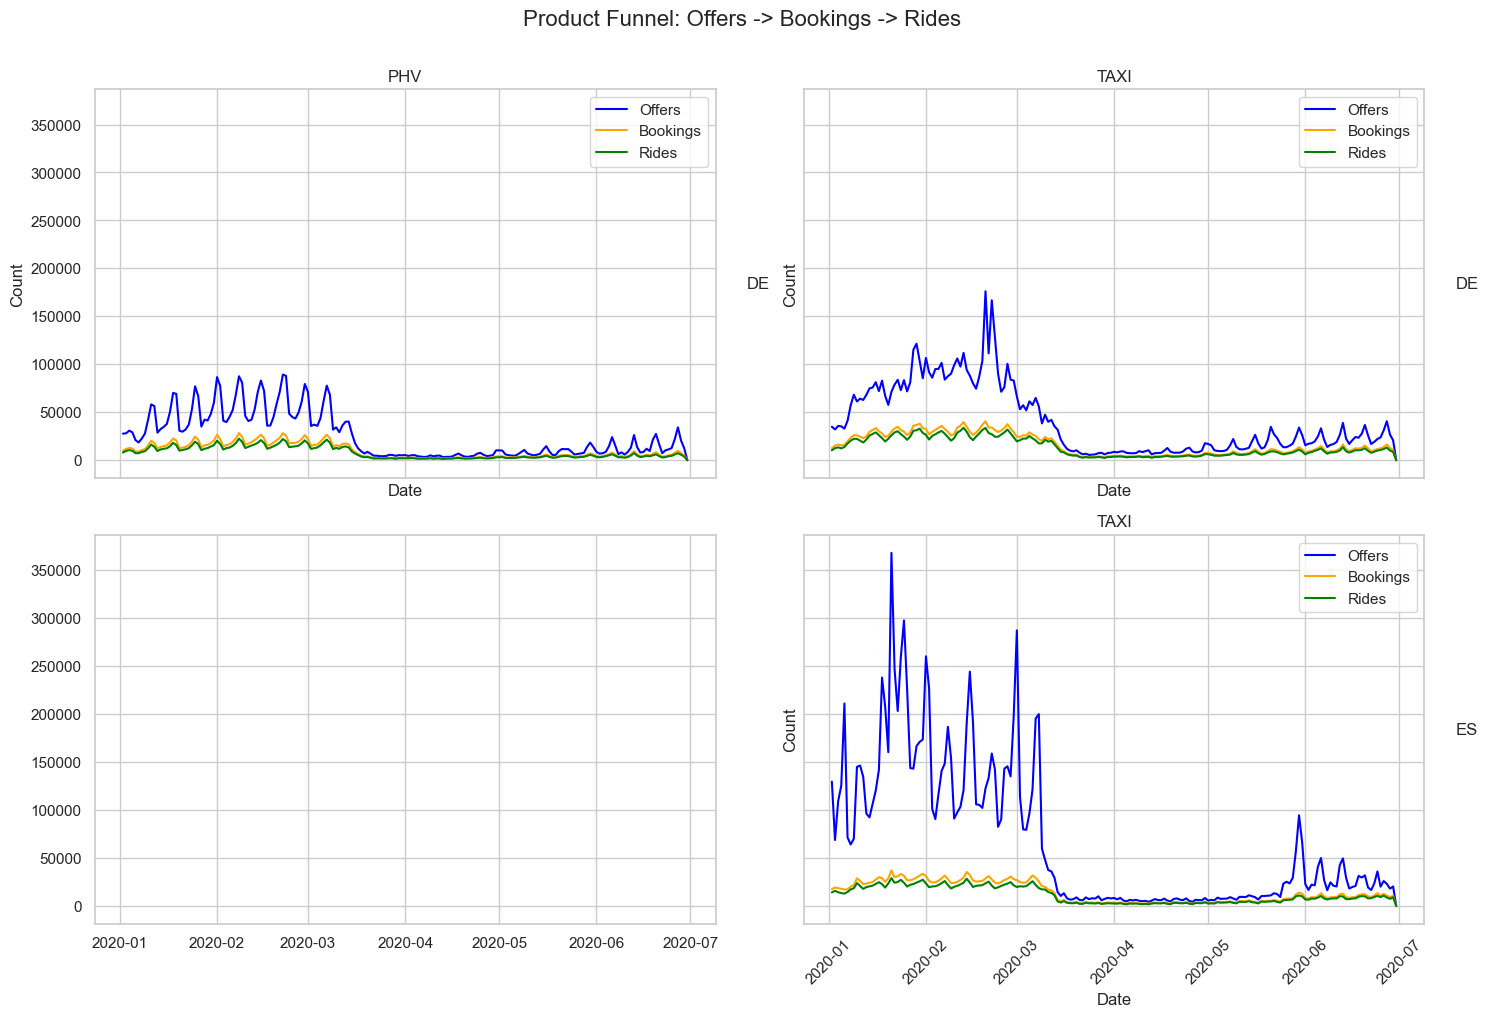

In [252]:
daily_funnel = df.groupby(['active_date', 'country_code', 'service_type'])[['offers', 'bookings', 'rides']].sum().reset_index()

first_date = daily_funnel['active_date'].min()
daily_funnel = daily_funnel[daily_funnel['active_date'] != first_date]

combinations = daily_funnel[['country_code', 'service_type']].drop_duplicates()

countries = daily_funnel['country_code'].unique()
service_types = daily_funnel['service_type'].unique()

fig, axes = plt.subplots(len(countries), len(service_types), figsize=(15, 10), sharex='all', sharey='all')

axes = axes.flatten()

for idx, (country, service) in enumerate(combinations.values):
    country_idx = list(countries).index(country)
    service_idx = list(service_types).index(service)
    
    subset = daily_funnel[(daily_funnel['country_code'] == country) & (daily_funnel['service_type'] == service)]
    
    ax = axes[country_idx * len(service_types) + service_idx]
    
    ax.plot(subset['active_date'], subset['offers'], label=f'Offers', color='blue', linestyle='-')
    ax.plot(subset['active_date'], subset['bookings'], label=f'Bookings', color='orange', linestyle='-')
    ax.plot(subset['active_date'], subset['rides'], label=f'Rides', color='green', linestyle='-')
    
    ax.set_title(f'{service}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.legend()
    
    ax.text(1.05, 0.5, country, transform=ax.transAxes, ha='left', va='center', fontsize=12)

fig.suptitle('Product Funnel: Offers -> Bookings -> Rides', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  
plt.xticks(rotation=45)
plt.show()

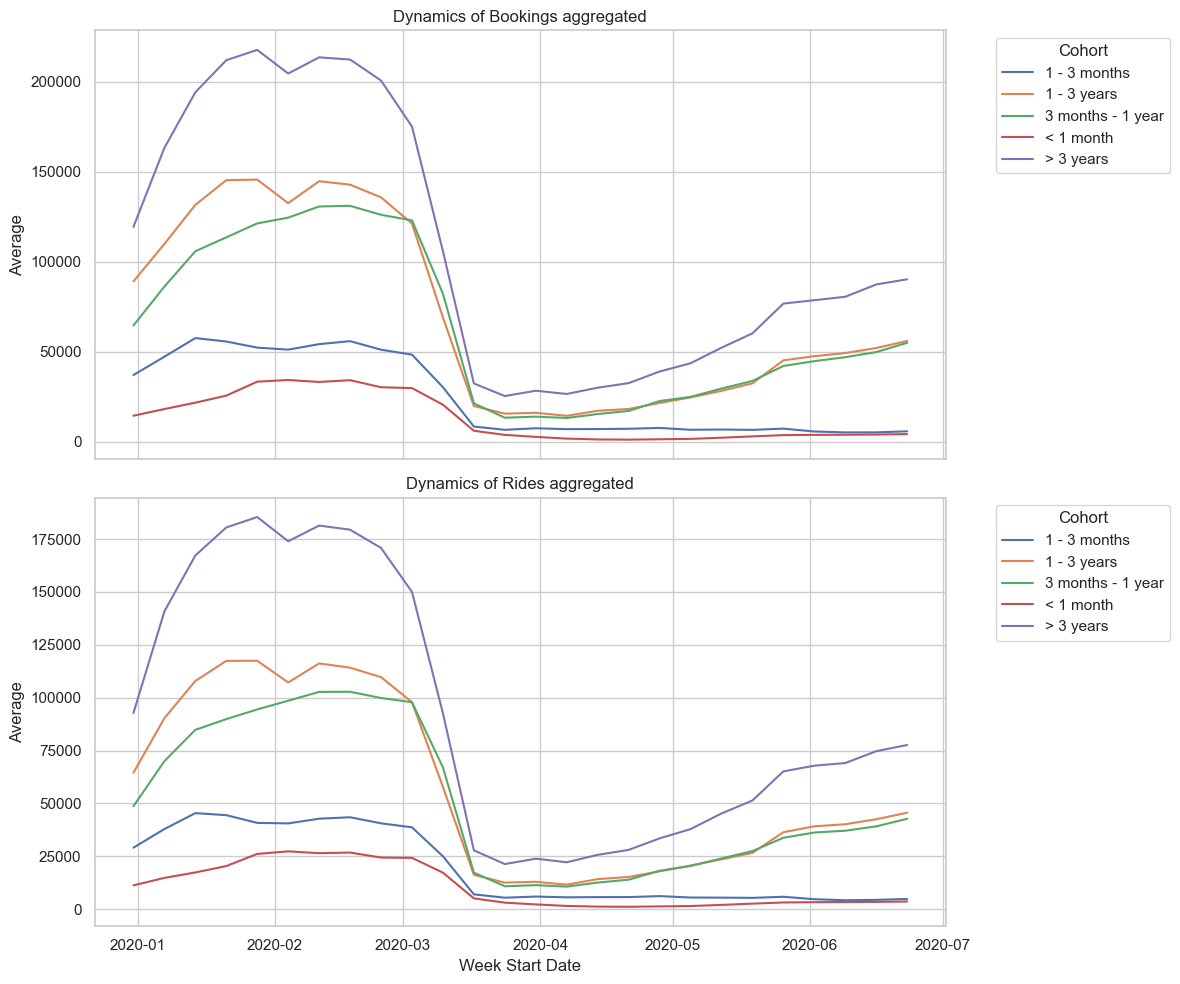

In [253]:
tmp = (
    df[['id_driver', 'week_start_act', 'bookings', 'rides', 'registration_cohort']]
    .groupby(['week_start_act', 'registration_cohort'])
    .agg(
        bookings_aggregated=('bookings', 'sum'),
        rides_aggregated=('rides', 'sum')
    )
    .reset_index()
)

last_date = tmp['week_start_act'].max()
tmp = tmp[tmp['week_start_act'] != last_date]

fields = ['bookings_aggregated', 'rides_aggregated']
titles = ['Dynamics of Bookings aggregated', 'Dynamics of Rides aggregated']

fig, axes = plt.subplots(len(fields), 1, figsize=(12, 10), sharex=True)

for i, field in enumerate(fields):
    ax = axes[i]
    sns.lineplot(
        data=tmp,
        x='week_start_act',
        y=field,
        hue='registration_cohort',
        ax=ax
    )
    ax.set_title(titles[i])
    ax.set_xlabel('Week Start Date' if i == len(fields) - 1 else '')
    ax.set_ylabel('Average')
    ax.grid(True)
    ax.legend(title='Cohort', loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

#### Drivers acquisition

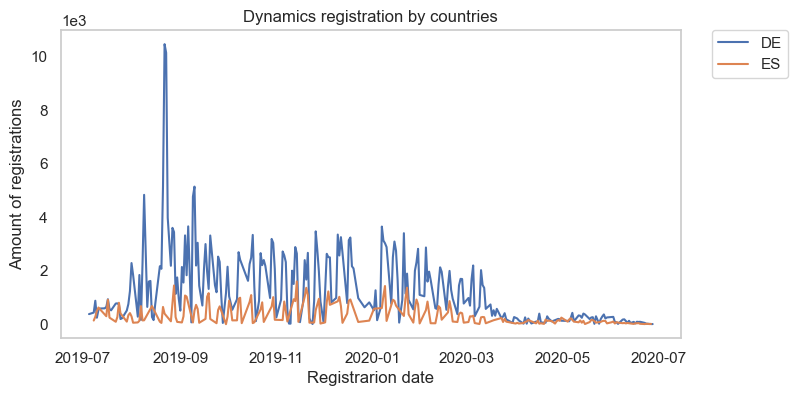

In [254]:
tmp = (
    df[['date_registration', 'country_code','id_driver']]
    .groupby(['date_registration','country_code'])
    .agg(count=('id_driver', 'count'))
    .reset_index()
)

min_dt = df['active_date'].min()

tmp = tmp[tmp['date_registration'] >= min_dt - pd.Timedelta(days=180)]

X = tmp['date_registration']
types = tmp['country_code'].unique()  

plt.figure(figsize=(8, 4))

for type in types:
    subset = tmp[tmp['country_code'] == type]  
    sns.lineplot(x=subset['date_registration'], y=subset['count'], label=f'{type}')  

plt.title('Dynamics registration by countries')
plt.xlabel('Registrarion date')
plt.ylabel('Amount of registrations')

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.grid()
plt.show()

#### Top perfomers

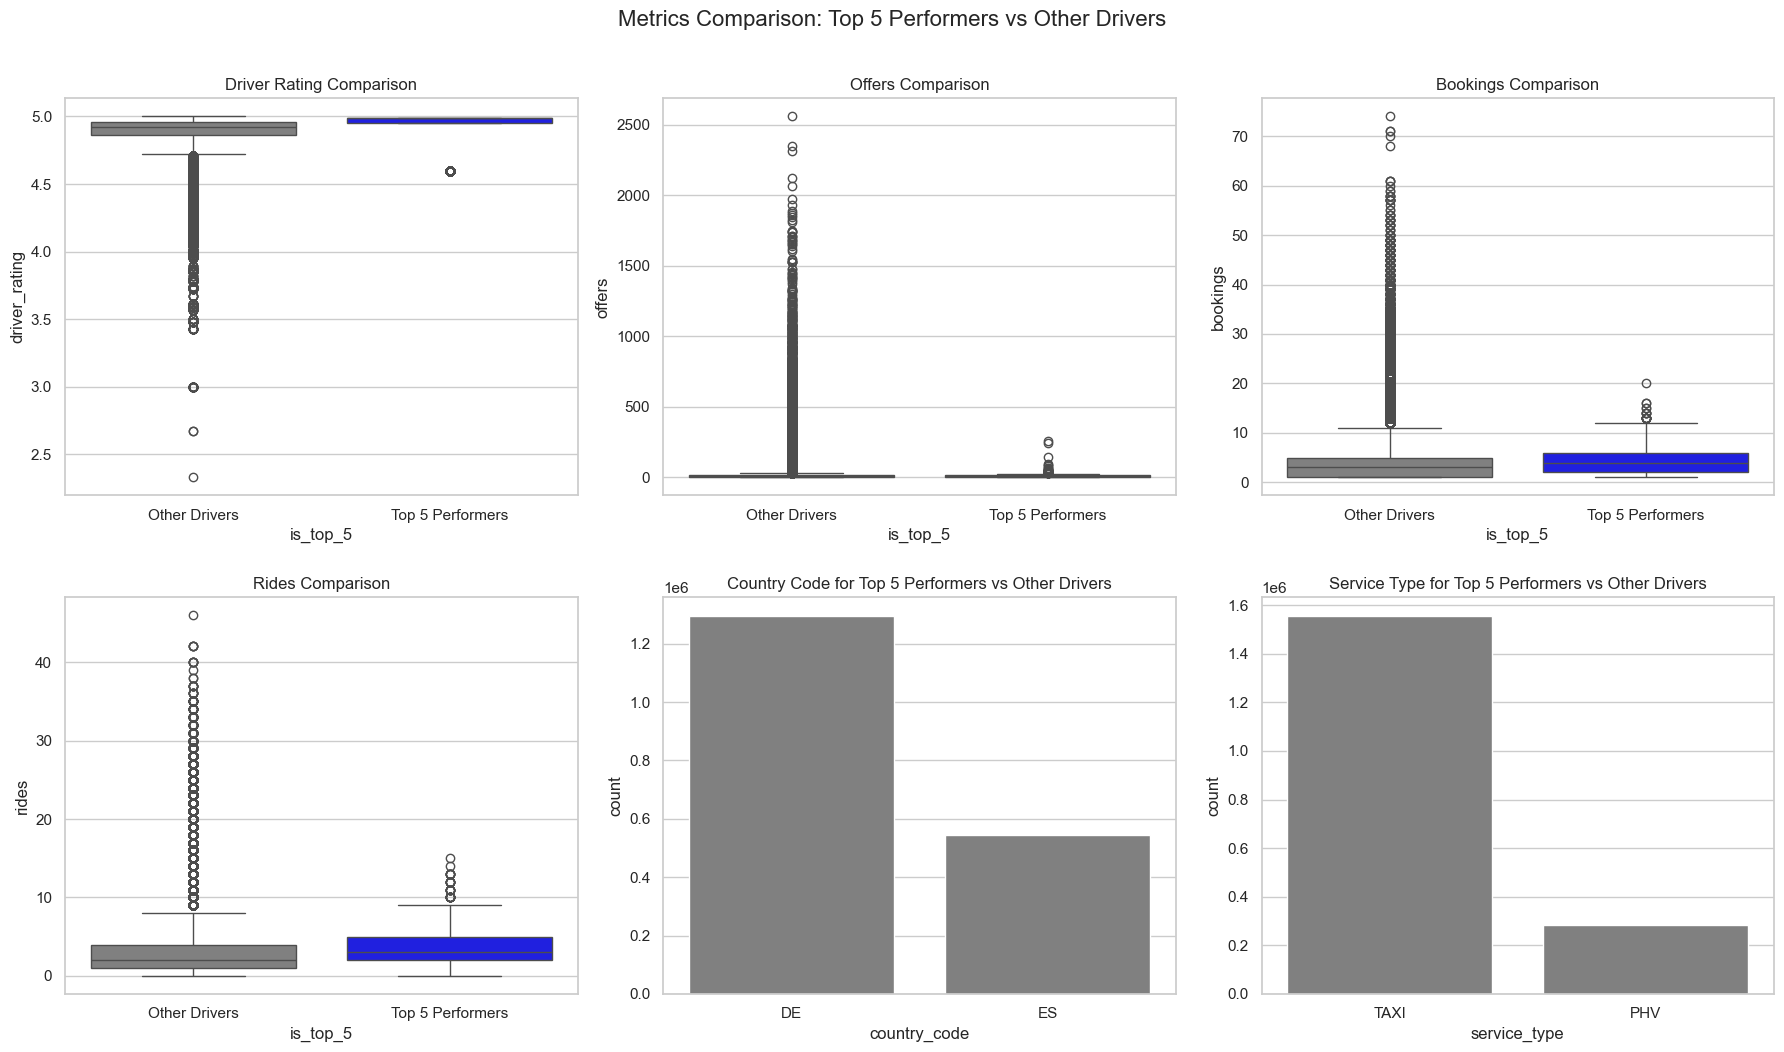

In [255]:
driver_performance = df.groupby('id_driver')['gold_level_count'].max().reset_index()

top_5_performers = driver_performance.nlargest(5, 'gold_level_count')

df['is_top_5'] = df['id_driver'].isin(top_5_performers['id_driver'])

top_5_performers_df = df[df['is_top_5'] == True]
other_drivers_df = df[df['is_top_5'] == False]

top_5_performers_metrics = top_5_performers_df[['id_driver', 'driver_rating', 'offers', 'bookings', 'rides', 'country_code', 'service_type']]
other_drivers_metrics = other_drivers_df[['id_driver', 'driver_rating', 'offers', 'bookings', 'rides', 'country_code', 'service_type']]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.boxplot(x='is_top_5', y='driver_rating', data=df, ax=axes[0, 0], palette={'True': 'blue', 'False': 'gray'})
axes[0, 0].set_title('Driver Rating Comparison')
axes[0, 0].set_xticklabels(['Other Drivers', 'Top 5 Performers'])

sns.boxplot(x='is_top_5', y='offers', data=df, ax=axes[0, 1], palette={'True': 'blue', 'False': 'gray'})
axes[0, 1].set_title('Offers Comparison')
axes[0, 1].set_xticklabels(['Other Drivers', 'Top 5 Performers'])

sns.boxplot(x='is_top_5', y='bookings', data=df, ax=axes[0, 2], palette={'True': 'blue', 'False': 'gray'})
axes[0, 2].set_title('Bookings Comparison')
axes[0, 2].set_xticklabels(['Other Drivers', 'Top 5 Performers'])

sns.boxplot(x='is_top_5', y='rides', data=df, ax=axes[1, 0], palette={'True': 'blue', 'False': 'gray'})
axes[1, 0].set_title('Rides Comparison')
axes[1, 0].set_xticklabels(['Other Drivers', 'Top 5 Performers'])

sns.countplot(x='country_code', data=top_5_performers_df, ax=axes[1, 1], color='blue')
sns.countplot(x='country_code', data=other_drivers_df, ax=axes[1, 1], color='gray')
axes[1, 1].set_title('Country Code for Top 5 Performers vs Other Drivers')

sns.countplot(x='service_type', data=top_5_performers_df, ax=axes[1, 2], color='blue')
sns.countplot(x='service_type', data=other_drivers_df, ax=axes[1, 2], color='gray')
axes[1, 2].set_title('Service Type for Top 5 Performers vs Other Drivers')

plt.tight_layout()
plt.suptitle('Metrics Comparison: Top 5 Performers vs Other Drivers', fontsize=16, y=1.05)
plt.show()


#### Days of the week with the highest unmet demand

   day_of_week  avg_offers  avg_rides  avg_dau  unsatisfied_demand
0            0   10.608951   2.897514    31509            7.711437
1            1   10.724972   3.017368    31439            7.707604
2            2   16.192420   3.163236    32654           13.029184
3            3   11.734671   3.187884    32345            8.546787
4            4   12.676618   3.283961    32804            9.392656
5            5   18.251866   3.676527    32330           14.575338
6            6   17.803943   3.461769    30906           14.342174
The day with the most unsatisfied demand is: 5.0


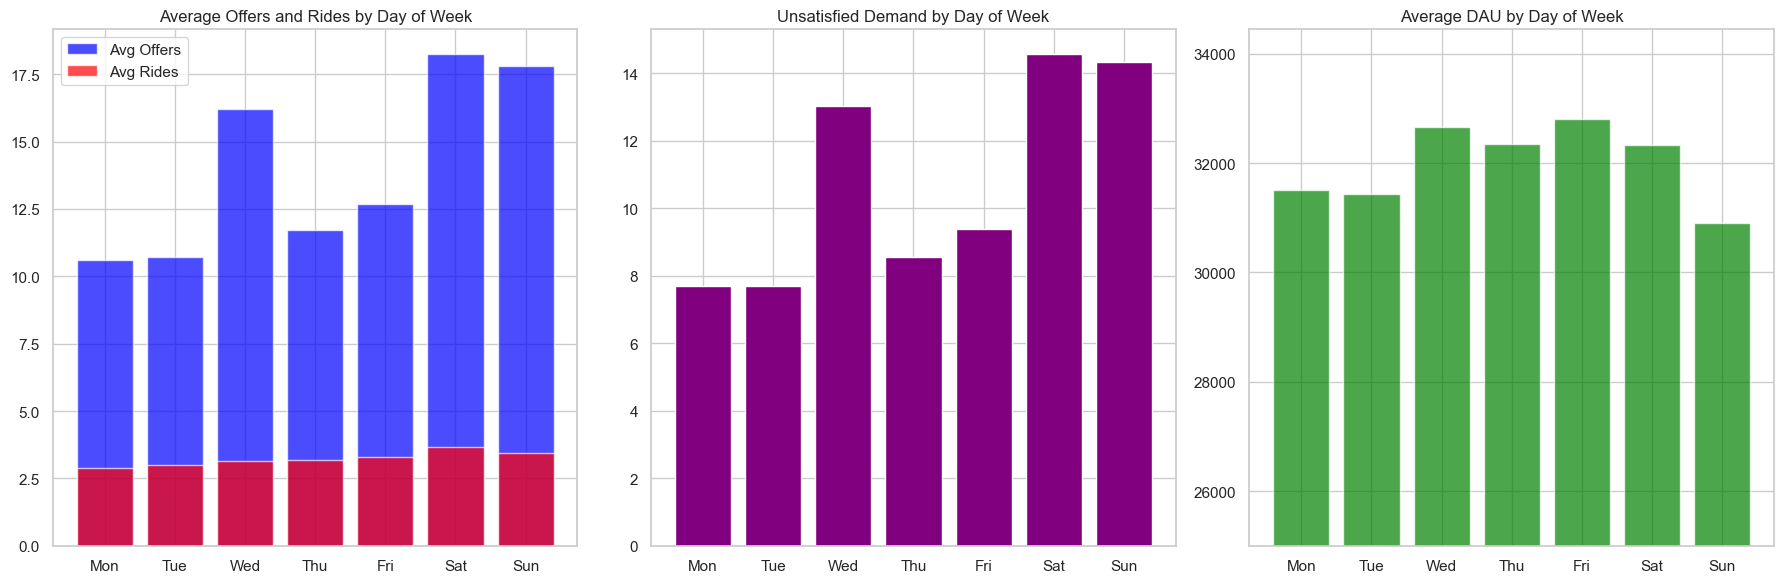

In [256]:
df['day_of_week'] = df['active_date'].dt.dayofweek

weekly_stats = df.groupby('day_of_week').agg(
    avg_offers=('offers', 'mean'),
    avg_rides=('rides', 'mean'),
    avg_dau=('id_driver', lambda x: x.nunique())  
).reset_index()

weekly_stats['unsatisfied_demand'] = weekly_stats['avg_offers'] - weekly_stats['avg_rides']

most_unsatisfied_day = weekly_stats.loc[weekly_stats['unsatisfied_demand'].idxmax()]

print(weekly_stats)
print(f"The day with the most unsatisfied demand is: {most_unsatisfied_day['day_of_week']}")

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].bar(weekly_stats['day_of_week'], weekly_stats['avg_offers'], color='blue', alpha=0.7, label='Avg Offers')
ax[0].bar(weekly_stats['day_of_week'], weekly_stats['avg_rides'], color='red', alpha=0.7, label='Avg Rides')
ax[0].set_title('Average Offers and Rides by Day of Week')
ax[0].set_xticks(range(7))
ax[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax[0].legend()

ax[1].bar(weekly_stats['day_of_week'], weekly_stats['unsatisfied_demand'], color='purple')
ax[1].set_title('Unsatisfied Demand by Day of Week')
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax[2].bar(weekly_stats['day_of_week'], weekly_stats['avg_dau'], color='green', alpha=0.7)
ax[2].set_title('Average DAU by Day of Week')
ax[2].set_xticks(range(7))
ax[2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax[2].set_ylim(bottom=25000)  

plt.tight_layout()
plt.show()

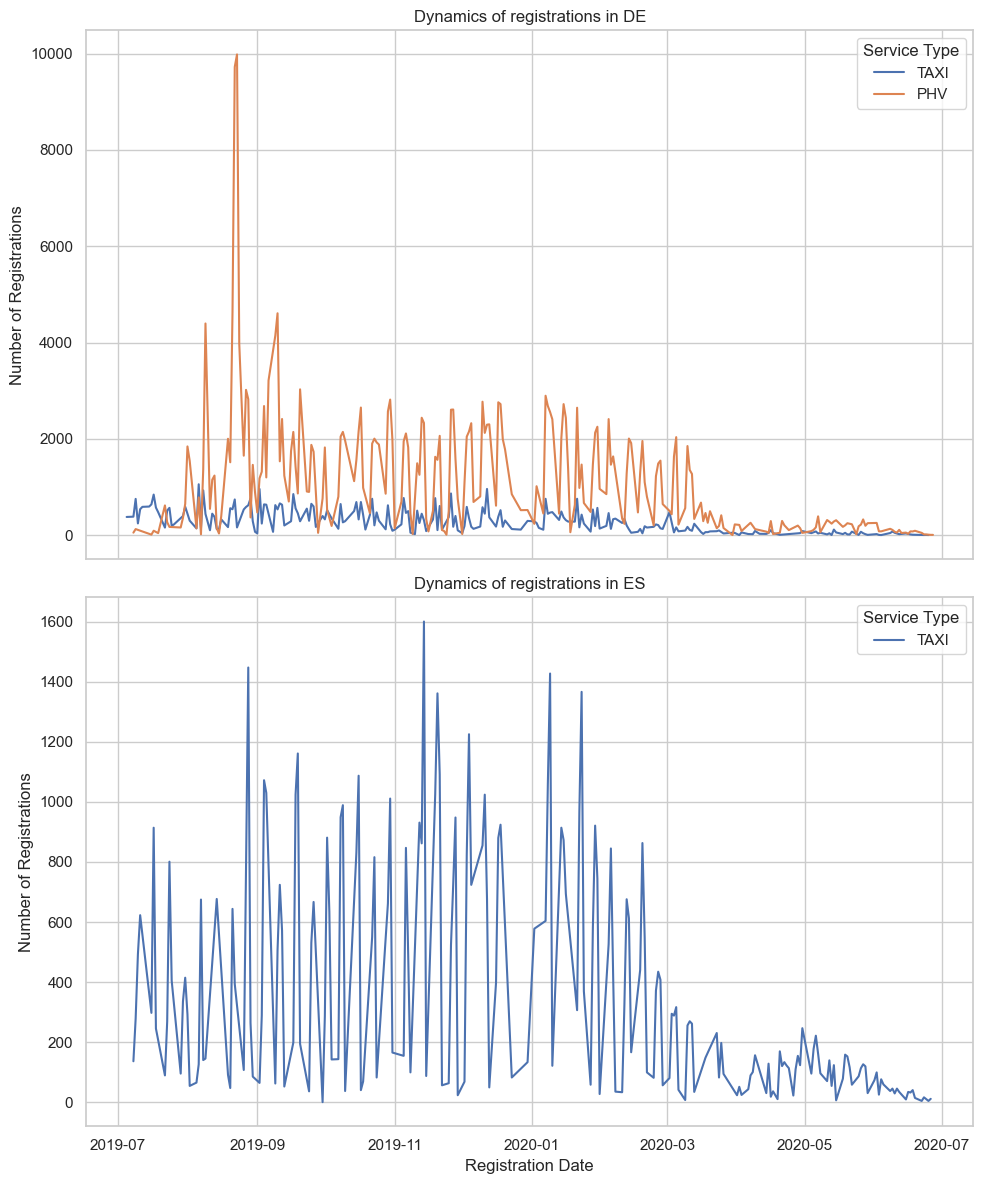

In [257]:
tmp = (
    df[['date_registration', 'country_code', 'service_type', 'id_driver']]
    .groupby(['date_registration', 'country_code', 'service_type'])
    .agg(count=('id_driver', 'count'))
    .reset_index()
)

min_dt = df['active_date'].min()
tmp = tmp[tmp['date_registration'] >= min_dt - pd.Timedelta(days=180)]

countries = tmp['country_code'].unique()

fig, axes = plt.subplots(len(countries), 1, figsize=(10, 6 * len(countries)), sharex=True)

for i, country in enumerate(countries):
    ax = axes[i]
    subset = tmp[tmp['country_code'] == country]
    
    sns.lineplot(
        data=subset,
        x='date_registration',
        y='count',
        hue='service_type',
        ax=ax
    )
    
    ax.set_title(f'Dynamics of registrations in {country}')
    ax.set_xlabel('Registration Date')
    ax.set_ylabel('Number of Registrations')
    ax.legend(title='Service Type')
    ax.grid(True)

plt.tight_layout()
plt.show()

#### Drivers performance by service types

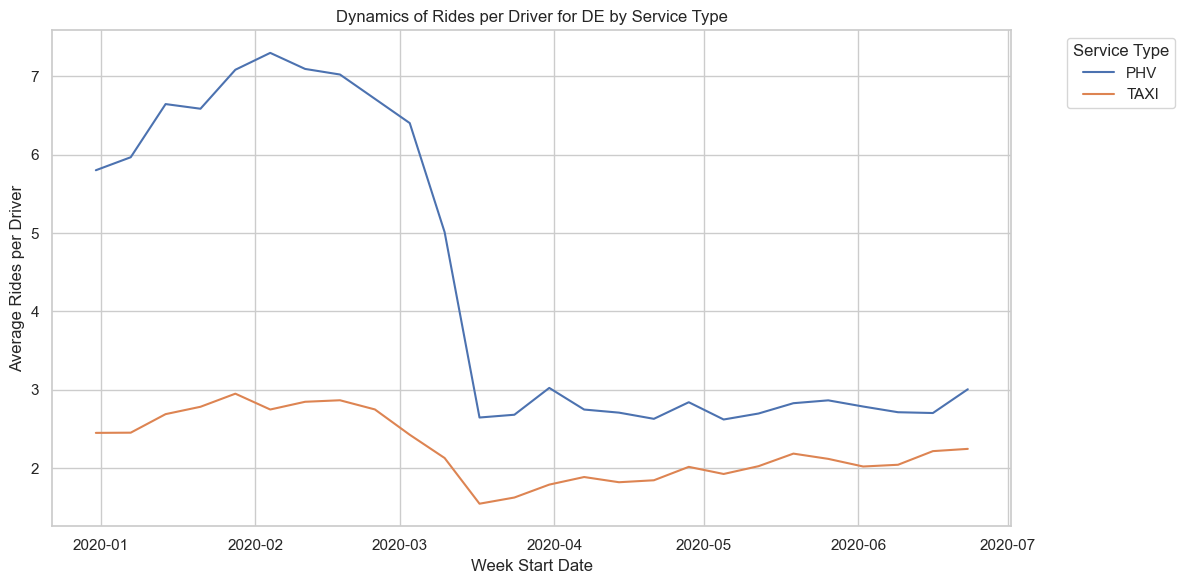

In [258]:
tmp = (
    df[df['country_code'] == 'DE'][['week_start_act', 'rides', 'service_type']]
    .groupby(['week_start_act', 'service_type'])
    .agg(rides_per_driver=('rides', 'mean'))
    .reset_index()
)

last_date = tmp['week_start_act'].max()
tmp = tmp[tmp['week_start_act'] != last_date]

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=tmp,
    x='week_start_act',
    y='rides_per_driver',
    hue='service_type'
)

plt.title('Dynamics of Rides per Driver for DE by Service Type')
plt.xlabel('Week Start Date')
plt.ylabel('Average Rides per Driver')
plt.grid(True)
plt.legend(title='Service Type', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

#### Distribution drivers with rides by registration cohort

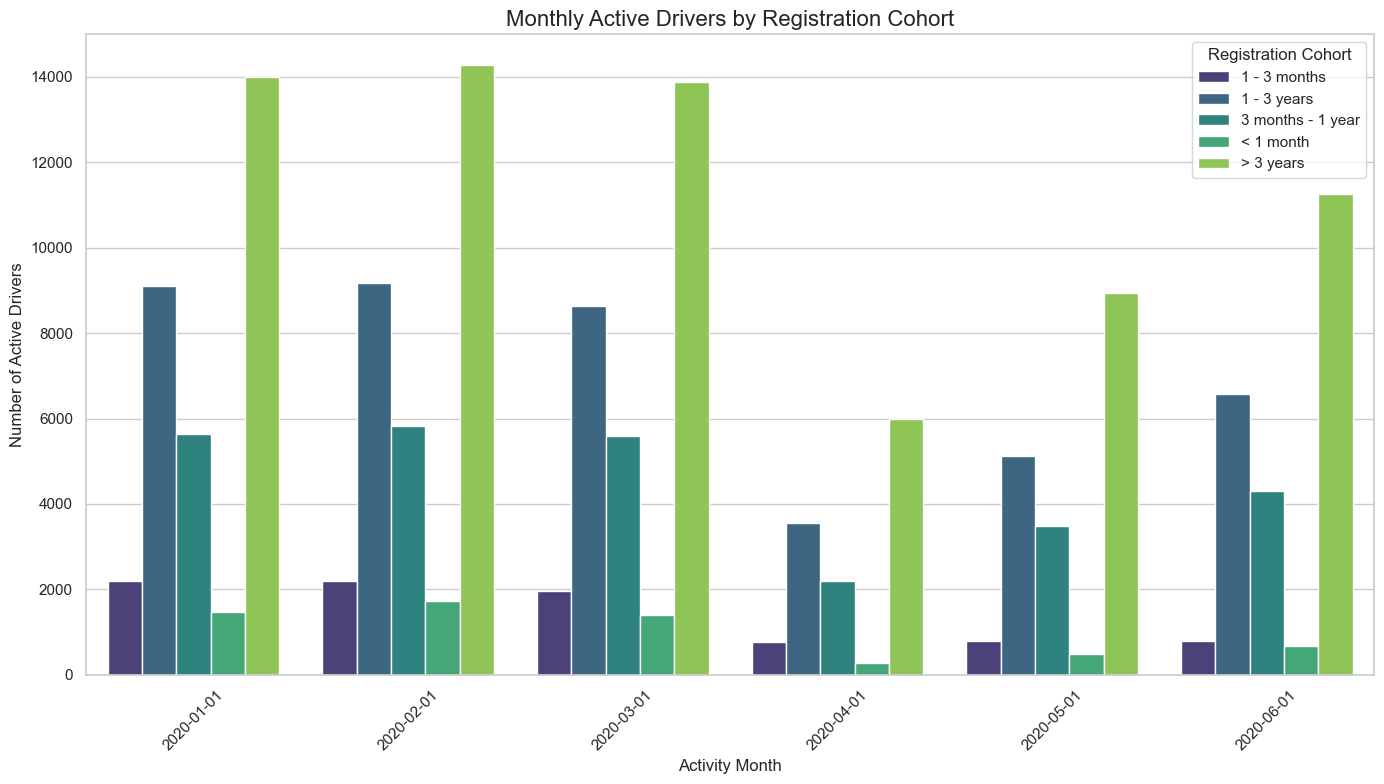

In [259]:
df['activity_month'] = df['active_date'].dt.to_period('M')

monthly_cohort_data = (
    df.groupby(['activity_month', 'registration_cohort'])['id_driver']
    .nunique()  
    .reset_index()
    .rename(columns={'id_driver': 'active_drivers'})
)

monthly_cohort_data['activity_month'] = monthly_cohort_data['activity_month'].dt.to_timestamp()

plt.figure(figsize=(14, 8))
sns.barplot(
    data=monthly_cohort_data,
    x='activity_month',
    y='active_drivers',
    hue='registration_cohort',
    palette='viridis'
)

plt.title('Monthly Active Drivers by Registration Cohort', fontsize=16)
plt.xlabel('Activity Month', fontsize=12)
plt.ylabel('Number of Active Drivers', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Registration Cohort')
plt.tight_layout()
plt.show()

#### Distribution by drivers rating

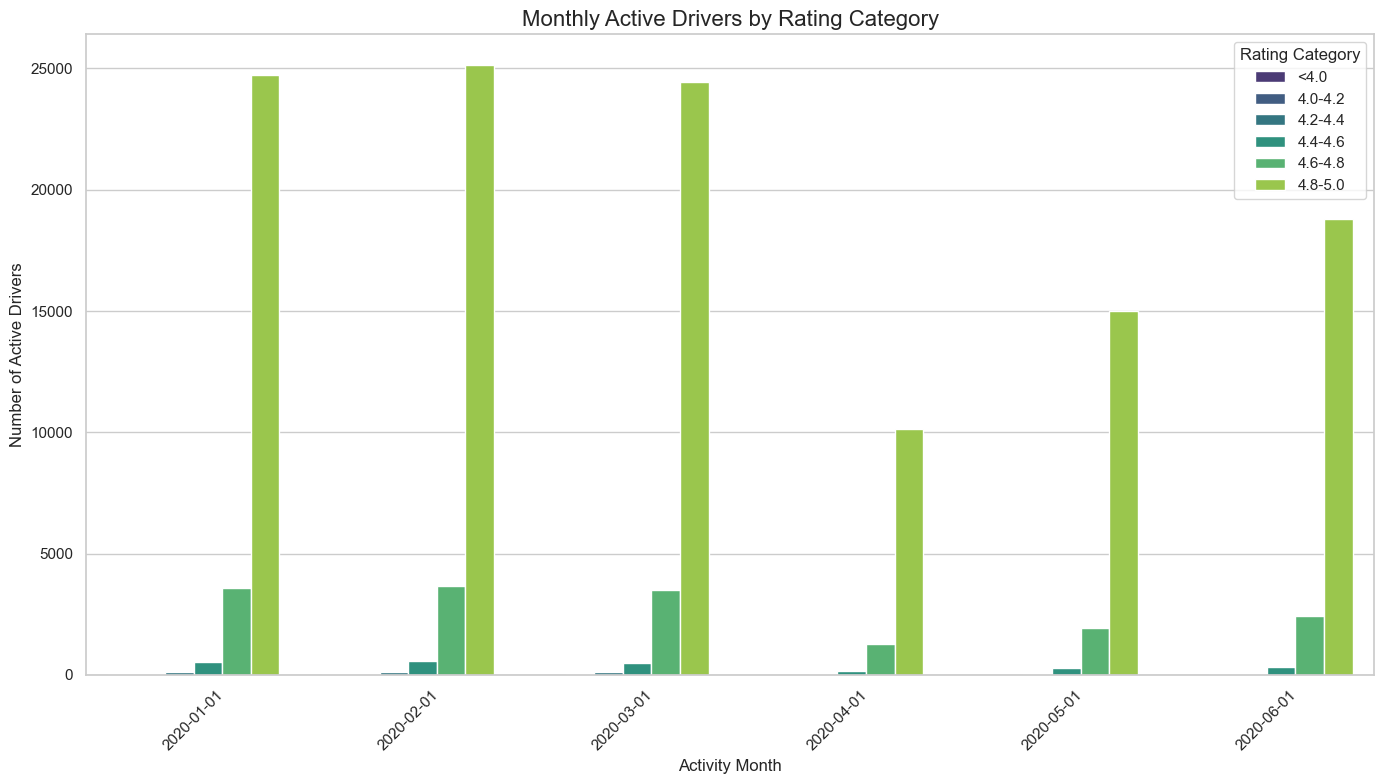

In [260]:
df['activity_month'] = df['active_date'].dt.to_period('M')

rating_bins = [0, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0]
rating_labels = ['<4.0', '4.0-4.2', '4.2-4.4', '4.4-4.6', '4.6-4.8', '4.8-5.0']
df['rating_category'] = pd.cut(df['driver_rating'], bins=rating_bins, labels=rating_labels, right=False)

monthly_rating_data = (
    df.groupby(['activity_month', 'rating_category'])['id_driver']
    .nunique()  
    .reset_index()
    .rename(columns={'id_driver': 'active_drivers'})
)

monthly_rating_data['activity_month'] = monthly_rating_data['activity_month'].dt.to_timestamp()

plt.figure(figsize=(14, 8))
sns.barplot(
    data=monthly_rating_data,
    x='activity_month',
    y='active_drivers',
    hue='rating_category',
    palette='viridis'
)

plt.title('Monthly Active Drivers by Rating Category', fontsize=16)
plt.xlabel('Activity Month', fontsize=12)
plt.ylabel('Number of Active Drivers', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Rating Category')
plt.tight_layout()
plt.show()

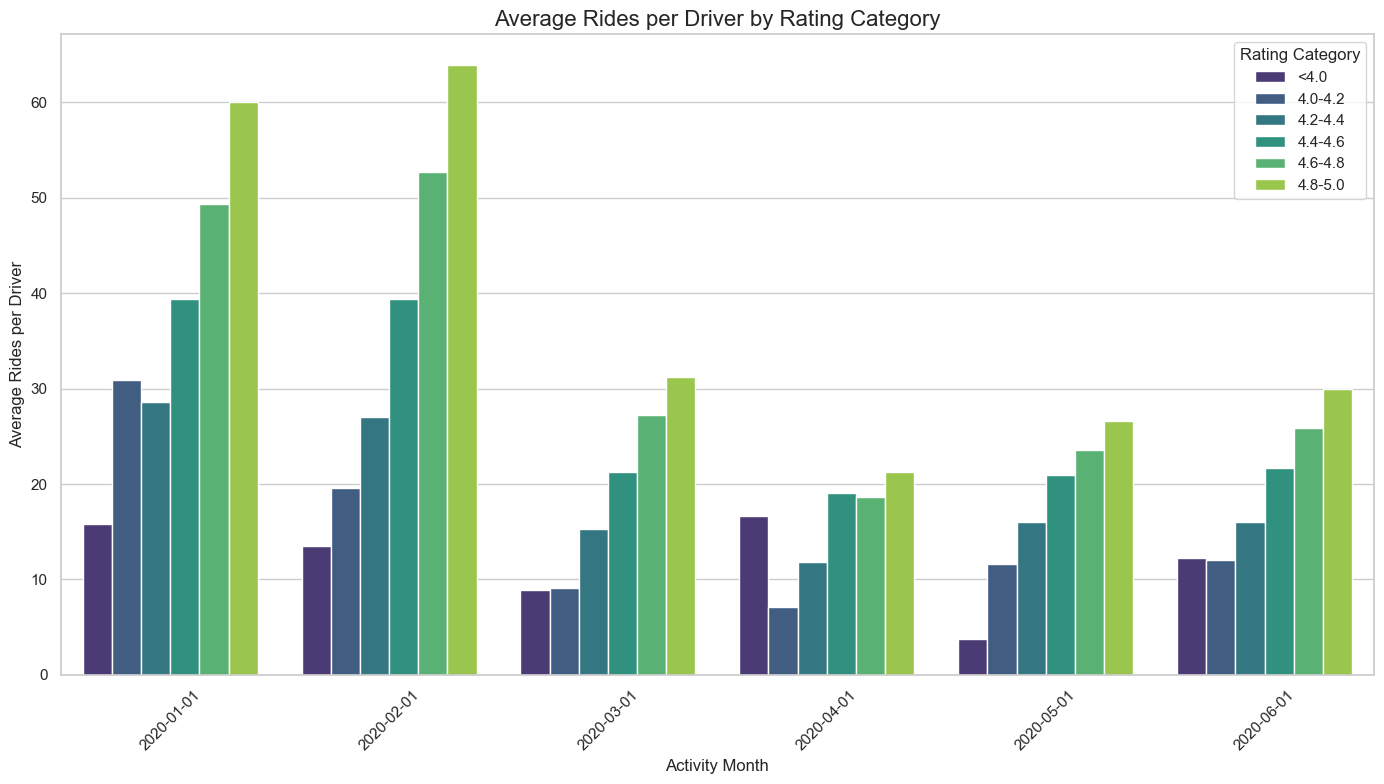

In [261]:
df['activity_month'] = df['active_date'].dt.to_period('M')

rating_bins = [0, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0]
rating_labels = ['<4.0', '4.0-4.2', '4.2-4.4', '4.4-4.6', '4.6-4.8', '4.8-5.0']
df['rating_category'] = pd.cut(df['driver_rating'], bins=rating_bins, labels=rating_labels, right=False)

monthly_rating_data = (
    df.groupby(['activity_month', 'rating_category'])
    .agg(
        total_rides=('rides', 'sum'),  
        unique_drivers=('id_driver', 'nunique')  
    )
    .reset_index()
)

monthly_rating_data['avg_rides_per_driver'] = (
    monthly_rating_data['total_rides'] / monthly_rating_data['unique_drivers']
)

monthly_rating_data['activity_month'] = monthly_rating_data['activity_month'].dt.to_timestamp()

plt.figure(figsize=(14, 8))
sns.barplot(
    data=monthly_rating_data,
    x='activity_month',
    y='avg_rides_per_driver',
    hue='rating_category',
    palette='viridis'
)

plt.title('Average Rides per Driver by Rating Category', fontsize=16)
plt.xlabel('Activity Month', fontsize=12)
plt.ylabel('Average Rides per Driver', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Rating Category')
plt.tight_layout()
plt.show()

#### Distribution by receive marketing

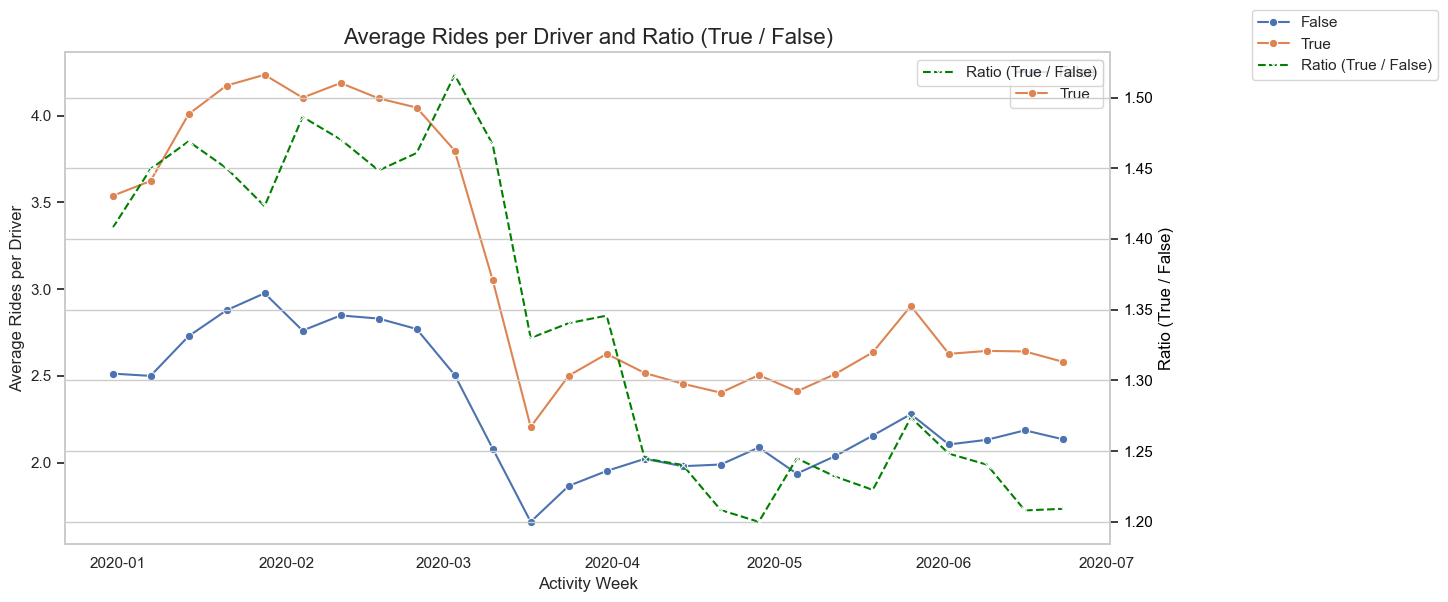

In [262]:
tmp = (
    df[['week_start_act', 'receive_marketing', 'rides']]
    .groupby(['week_start_act', 'receive_marketing'])
    .agg(rides_per_driver=('rides', 'mean'))  
    .reset_index()
)

tmp = tmp.iloc[:-2]  

pivot = tmp.pivot(index='week_start_act', columns='receive_marketing', values='rides_per_driver')
pivot['ratio'] = pivot[True] / pivot[False]  

fig, ax1 = plt.subplots(figsize=(12, 6))

types = tmp['receive_marketing'].unique()
for type in types:
    subset = tmp[tmp['receive_marketing'] == type]
    sns.lineplot(ax=ax1, x=subset['week_start_act'], y=subset['rides_per_driver'], label=f'{type}', marker='o')

ax1.set_ylabel('Average Rides per Driver', fontsize=12)
ax1.set_xlabel('Activity Week', fontsize=12)
ax1.tick_params(axis='y')
ax1.set_title('Average Rides per Driver and Ratio (True / False)', fontsize=16)

ax2 = ax1.twinx()
sns.lineplot(ax=ax2, x=pivot.index, y=pivot['ratio'], label='Ratio (True / False)', color='green', linestyle='--', marker='x')
ax2.set_ylabel('Ratio (True / False)', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
ax1.grid()
plt.tight_layout()
plt.show()

#### Comparing ratio-metrics within the countries

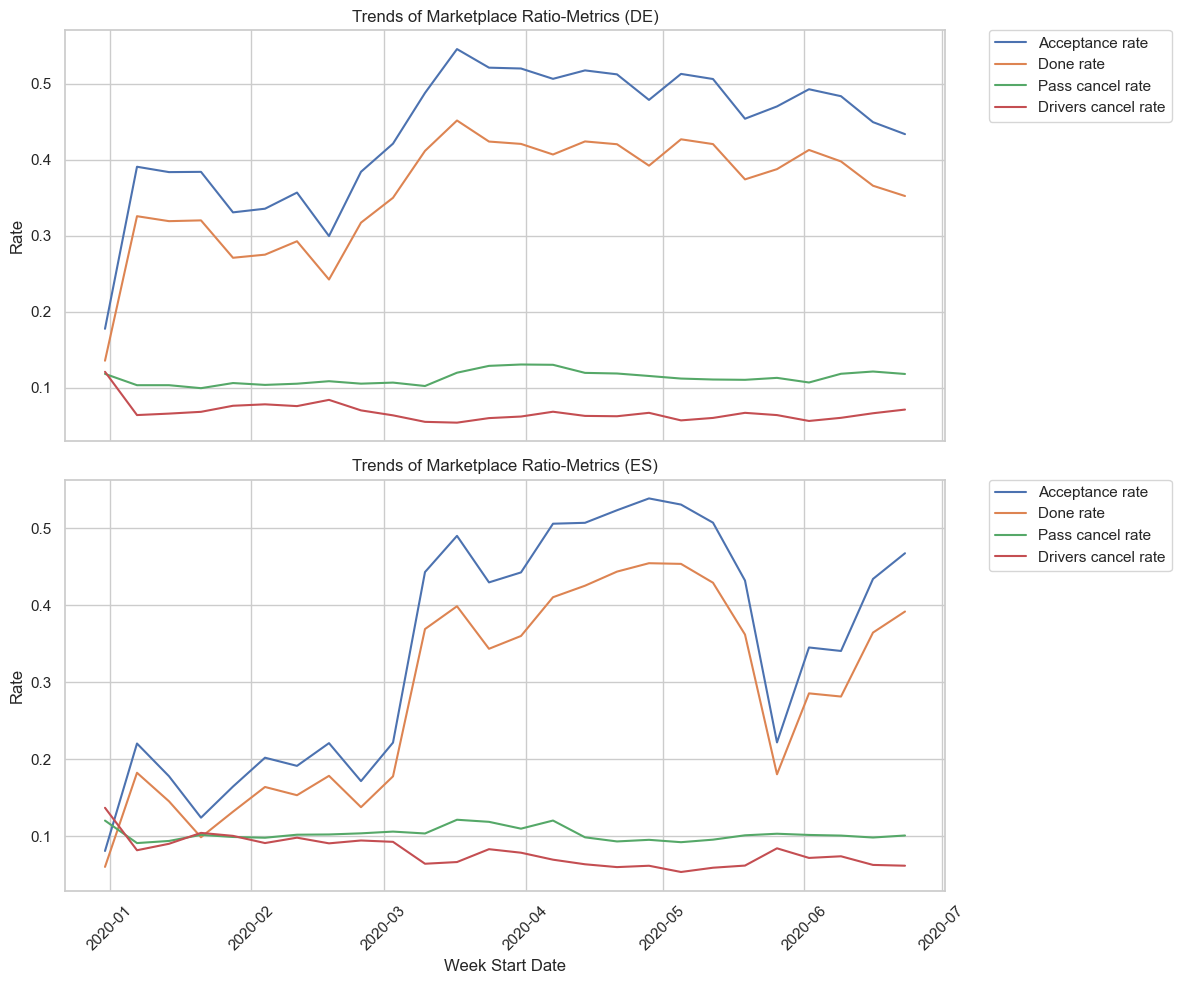

In [263]:
def process_country_data(df, country_code):
    country_df = (
        df[df['country_code'] == country_code]
        .groupby(['week_start_act'])
        .agg(
            offers=('offers', 'sum'),
            bookings=('bookings', 'sum'),
            bookings_cancelled_by_passenger=('bookings_cancelled_by_passenger', 'sum'),
            bookings_cancelled_by_driver=('bookings_cancelled_by_driver', 'sum'),
            rides=('rides', 'sum')
        )
        .reset_index()
    )
    country_df['Acceptance rate'] = country_df['bookings'] / country_df['offers']
    country_df['Done rate'] = country_df['rides'] / country_df['offers']
    country_df['Pass cancel rate'] = country_df['bookings_cancelled_by_passenger'] / country_df['bookings']
    country_df['Drivers cancel rate'] = country_df['bookings_cancelled_by_driver'] / country_df['bookings']
    
    last_date = country_df['week_start_act'].max()
    return country_df[country_df['week_start_act'] != last_date]

filtered_act_DE = process_country_data(df, 'DE')
filtered_act_ES = process_country_data(df, 'ES')

fields = ['Acceptance rate', 'Done rate', 'Pass cancel rate', 'Drivers cancel rate']

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for i, (filtered_act, title) in enumerate(zip([filtered_act_DE, filtered_act_ES], 
                                              ['Trends of Marketplace Ratio-Metrics (DE)', 
                                               'Trends of Marketplace Ratio-Metrics (ES)'])):
    for field in fields:
        sns.lineplot(ax=axes[i], x=filtered_act['week_start_act'], y=filtered_act[field], label=field)
    axes[i].set_title(title)
    axes[i].set_ylabel('Rate')
    axes[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
    axes[i].grid(True)

axes[1].set_xlabel('Week Start Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()